In [18]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from back_tester import * 
from deep_q_learning_improved import *
from collections import Counter
import os



# Fix seed for reproducibility
---

In [19]:
# ─── FIX RANDOM SEEDS ───────────────────────────────────────────────────────────
SEED = 42
random.seed(SEED) #Sets the seed for Python’s built-in random module.
np.random.seed(SEED) #Sets the seed for NumPy’s random number generator.
torch.manual_seed(SEED) #Sets the seed for PyTorch CPU operations.
# if you’re using CUDA:
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # make CuDNN deterministic (may slow you down a bit)
    torch.backends.cudnn.deterministic   = True
    torch.backends.cudnn.benchmark       = False
# ────────────────────────────────────────────────────────────────────────────────



# Load data
---

* ## In sample data

In [20]:
#Data
prices = pd.read_csv('tardis_data/final_training_set/final_training_set_5min_2024.csv', index_col=0,parse_dates=True)
#prices = pd.read_csv("tardis_data/final_training_set/final_training_set_top_10.csv", index_col=0, parse_dates=True)

#prices = prices[['MANAUSDT_2024_5m', 'SANDUSDT_2024_5m']]

#Filter for AXSUSDT_2024_5m ~ SANDUSDT_2024_5m
#prices = prices[['AXSUSDT_2024_5m', 'SANDUSDT_2024_5m']]

#Filter for AXSUSDT_2024_5m ~ MANAUSDT_2024_5m
#prices = prices[['AXSUSDT_2024_5m', 'MANAUSDT_2024_5m']]

prices


,SANDUSDT_2024_5m,MANAUSDT_2024_5m,AXSUSDT_2024_5m
timestamp,,,
2024-01-01 00:00:00,0.6006,0.5239,8.880
2024-01-01 00:05:00,0.5971,0.5228,8.870
2024-01-01 00:10:00,0.5979,0.5228,8.870
2024-01-01 00:15:00,0.5941,0.5213,8.850
2024-01-01 00:20:00,0.5947,0.5218,8.850
...,...,...,...
2024-12-31 23:35:00,0.5445,0.4651,6.195
2024-12-31 23:40:00,0.5451,0.4661,6.199
2024-12-31 23:45:00,0.5466,0.4669,6.214


In [12]:
prices = prices.loc['2024-01-01 00:00:00':'2024-06-29 23:55:00']
prices

,SANDUSDT_2024_5m,MANAUSDT_2024_5m,AXSUSDT_2024_5m
timestamp,,,
2024-01-01 00:00:00,0.6006,0.5239,8.880
2024-01-01 00:05:00,0.5971,0.5228,8.870
2024-01-01 00:10:00,0.5979,0.5228,8.870
2024-01-01 00:15:00,0.5941,0.5213,8.850
2024-01-01 00:20:00,0.5947,0.5218,8.850
...,...,...,...
2024-06-29 23:20:00,0.3263,0.3312,5.957
2024-06-29 23:35:00,0.3261,0.3311,5.960
2024-06-29 23:40:00,0.3259,0.3307,5.952


In [9]:
prices_original = prices = pd.read_csv('tardis_data/final_in_sample_dataset/final_in_sample_dataset_5min_2024.csv', index_col=0, parse_dates=True)
prices_original_relevant_tickers = prices_original[['SANDUSDT_2024_5m','MANAUSDT_2024_5m','AXSUSDT_2024_5m']]
prices_original_relevant_tickers

,SANDUSDT_2024_5m,MANAUSDT_2024_5m,AXSUSDT_2024_5m
timestamp,,,
2024-01-01 00:00:00,0.6006,0.5239,8.880
2024-01-01 00:05:00,0.5971,0.5228,8.870
2024-01-01 00:10:00,0.5979,0.5228,8.870
2024-01-01 00:15:00,0.5941,0.5213,8.850
2024-01-01 00:20:00,0.5947,0.5218,8.850
...,...,...,...
2024-06-29 23:20:00,0.3263,0.3312,5.957
2024-06-29 23:35:00,0.3261,0.3311,5.960
2024-06-29 23:40:00,0.3259,0.3307,5.952


In [17]:
prices.equals(prices_original_relevant_tickers)

False

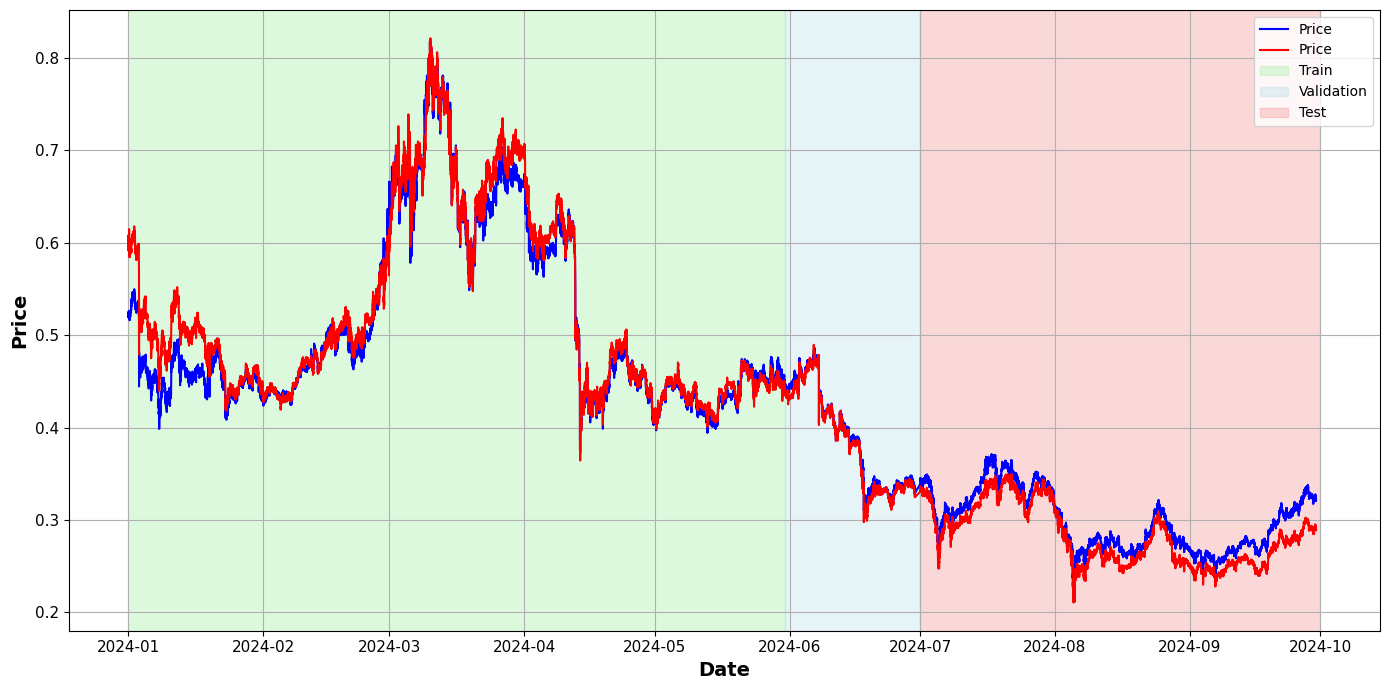

In [6]:
import matplotlib.pyplot as plt

# Define your split dates
split_1_end = '2024-05-30 23:55:00'
split_2_end = '2024-06-30 23:55:00'
split_3_end = '2024-09-30 23:55:00'

# Prepare the data
prices_for_plot = prices[:split_3_end]

# Plot the price series
plt.figure(figsize=(14, 7))
plt.plot(prices_for_plot[prices_for_plot.columns[0]], label='Price', color='blue')
plt.plot(prices_for_plot[prices_for_plot.columns[1]], label='Price', color='red')


# Add shaded regions
plt.axvspan(prices_for_plot.index[0], split_1_end, color='lightgreen', alpha=0.3, label='Train')
plt.axvspan(split_1_end, split_2_end, color='lightblue', alpha=0.3, label='Validation')
plt.axvspan(split_2_end, split_3_end, color='lightcoral', alpha=0.3, label='Test')

# Add labels and legend
#plt.title('Price Series with Train/Validation/Test Splits')
plt.xlabel('Date', fontsize = 14, fontweight='bold')
plt.ylabel('Price', fontsize = 14, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig('price_series_with_splits.png', dpi=300, bbox_inches='tight')

plt.show()


* ## Out of sample data

In [294]:
# #prices_out_of_sample = pd.read_csv('tardis_data/final_out_of_sample_dataset_5min/final_out_of_sample_dataset_5min.csv', index_col=0, parse_dates=True)
# prices_out_of_sample = pd.read_csv('tardis_data/final_testing_set/final_test_set_5min_2025.csv',index_col=0, parse_dates=True)
# #Filter for MANAUSDT_2024_5m ~ SANDUSDT_2024_5m
# prices_out_of_sample = prices_out_of_sample[['MANAUSDT_2024_5m', 'SANDUSDT_2024_5m']]
# prices_out_of_sample

* ## Training set

---

In [295]:

#prices_train = prices.loc['2024-01-01 00:00:00':'2024-04-30 23:55:00'] #January training data

prices_train = prices.loc['2024-01-01 00:00:00':'2024-05-30 23:55:00'] #January training data

#prices_train = prices

#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_train, sym2_train = prices_train.columns
S1_train = prices_train[sym1_train]
S2_train = prices_train[sym2_train]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_train, beta_series_train, alpha_series_train = compute_spread_series(S1_train, S2_train, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_train, rolling_mean_train, rolling_std_train = compute_rolling_zscore(spread_series_train, window_size)

#Drop NaN values from zscore_series
zscore_series_train = zscore_series_train.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_train = prices_train.loc[zscore_series_train.index]
beta_series_train = beta_series_train.loc[zscore_series_train.index]



Computing spread series and beta series...


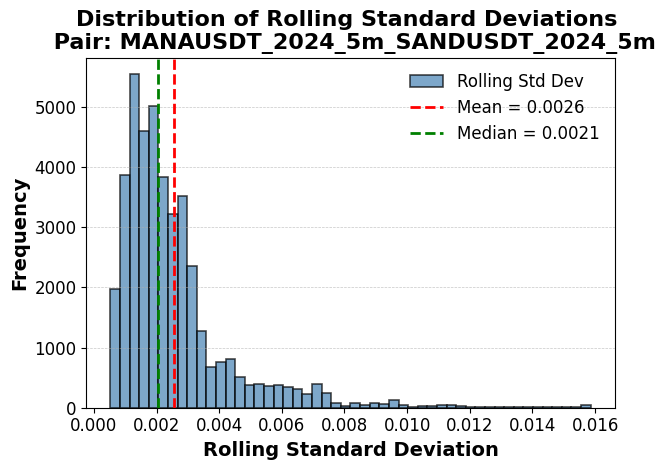

In [296]:

# Set figure size and dpi for sharpness
#plt.figure(figsize=(8, 6), dpi=300)

# Plot histogram with thicker edge and more visible bars
plt.hist(rolling_std_train, bins=50, alpha=0.7, color='steelblue', edgecolor='black', linewidth=1.2, label='Rolling Std Dev')

# Add mean line, thicker
plt.axvline(rolling_std_train.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean = {rolling_std_train.mean():.4f}')

# Add median line, thicker
plt.axvline(rolling_std_train.median(), color='green', linestyle='--', linewidth=2, 
            label=f'Median = {rolling_std_train.median():.4f}')

# Add title with larger, bold font
plt.title(f'Distribution of Rolling Standard Deviations \n Pair: {sym1_train}_{sym2_train}', fontsize=16, fontweight='bold')

# Add axis labels with larger font
plt.xlabel('Rolling Standard Deviation', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# Customize tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend with larger font, no frame
plt.legend(fontsize=12, frameon=False)

# Optional: Add subtle grid
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Tight layout
plt.tight_layout()

# Save the plot as a high-resolution PNG file

file_path =  f'results/reinforcement_learning/{sym1_train}_{sym2_train}/rolling_beta_distribution_{sym1_train}_{sym2_train}.png'

os.makedirs(os.path.dirname(file_path), exist_ok=True)  # Ensure the directory exists
plt.savefig(file_path, dpi=300, bbox_inches='tight')


# Show plot
plt.show()


Spread series mean: 0.0002123529610820506, std: 0.0037521387218462676


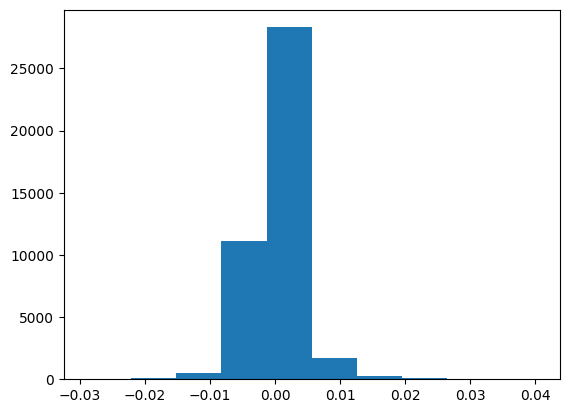

In [297]:
plt.hist(spread_series_train)
print(f"Spread series mean: {spread_series_train.mean()}, std: {spread_series_train.std()}")

In [298]:
prices_train

,MANAUSDT_2024_5m,SANDUSDT_2024_5m
timestamp,,
2024-01-03 00:50:00,0.5315,0.5883
2024-01-03 00:55:00,0.5323,0.5892
2024-01-03 01:00:00,0.5331,0.5904
2024-01-03 01:05:00,0.5327,0.5897
2024-01-03 01:10:00,0.5323,0.5899
...,...,...
2024-05-30 23:35:00,0.4454,0.4386
2024-05-30 23:40:00,0.4452,0.4386
2024-05-30 23:45:00,0.4457,0.4389


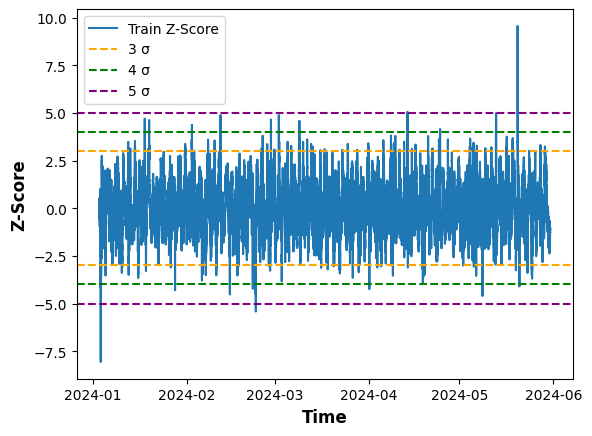

In [300]:
plt.plot(zscore_series_train, label='Train Z-Score')
plt.axhline(3, color='orange', linestyle='--', label='3 σ')
plt.axhline(-3, color='orange', linestyle='--')
plt.axhline(4, color='g', linestyle='--', label='4 σ')
plt.axhline(-4, color='g', linestyle='--',)
plt.axhline(5, color='purple', linestyle='--', label='5 σ')
plt.axhline(-5, color='purple', linestyle='--')
#plt.title('Z-Score Spread Train', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=12, fontweight='bold')
plt.ylabel('Z-Score', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.savefig('z_score_spread_train.png', dpi=300, bbox_inches='tight')

---

* ## Validation set

---

In [258]:

#prices_val = prices.loc['2024-05-01 00:00:00':'2024-05-31 23:55:00'] #May val data
prices_val = prices.loc['2024-06-01 00:00:00':'2024-06-30 23:55:00'] #May val data
#prices_val = prices_out_of_sample.loc['2025-01-01 00:00:00':'2025-02-28 23:55:00'] #January-Feb 2025 val data


#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_val, sym2_val = prices_val.columns
S1_val = prices_val[sym1_val]
S2_val = prices_val[sym2_val]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_val, beta_series_val, alpha_series_val = compute_spread_series(S1_val, S2_val, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_val, rolling_mean_val, rolling_std_val = compute_rolling_zscore(spread_series_val, window_size)

#Drop NaN values from zscore_series
zscore_series_val = zscore_series_val.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_val = prices_val.loc[zscore_series_val.index]
beta_series_val = beta_series_val.loc[zscore_series_val.index]


Computing spread series and beta series...


In [259]:
prices_val

,AXSUSDT_2024_5m,MANAUSDT_2024_5m
timestamp,,
2024-06-03 01:15:00,7.752,0.4433
2024-06-03 01:20:00,7.797,0.4458
2024-06-03 01:25:00,7.778,0.4464
2024-06-03 01:30:00,7.801,0.4474
2024-06-03 01:35:00,7.798,0.4468
...,...,...
2024-06-29 23:20:00,5.957,0.3312
2024-06-29 23:35:00,5.960,0.3311
2024-06-29 23:40:00,5.952,0.3307


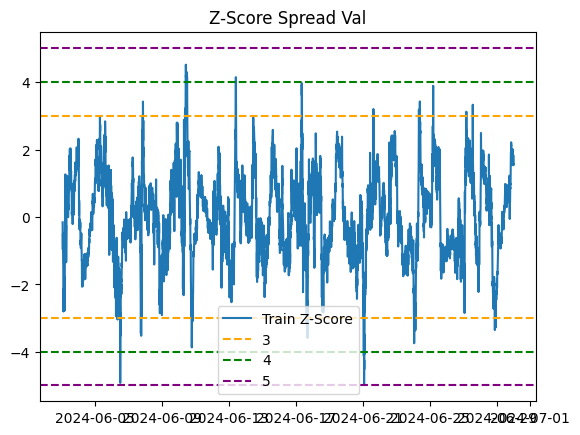

In [260]:
plt.plot(zscore_series_val, label='Train Z-Score')
plt.axhline(3, color='orange', linestyle='--', label='3')
plt.axhline(-3, color='orange', linestyle='--')
plt.axhline(4, color='g', linestyle='--', label='4')
plt.axhline(-4, color='g', linestyle='--',)
plt.axhline(5, color='purple', linestyle='--', label='5')
plt.axhline(-5, color='purple', linestyle='--')
plt.title('Z-Score Spread Val')
plt.legend()

---

* ## Test set

---

In [261]:

#prices_test = prices.loc['2024-06-01 00:00:00':'2024-06-29 23:55:00']
#prices_test = prices.loc['2024-06-01 00:00:00':'2024-06-30 23:55:00']

#prices_test = prices.loc['2024-05-01 00:00:00':'2024-06-30 23:55:00'] #May and June test data

prices_test = prices.loc['2024-07-01 00:00:00':'2024-09-30 23:55:00'] #July to September test data

#Test set is the out-of-sample data
#prices_test = prices_out_of_sample.loc['2025-03-01 00:00:00':'2025-03-31 23:55:00'] #March 2025 test data

#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_test, sym2_test = prices_test.columns
S1_test = prices_test[sym1_test]
S2_test = prices_test[sym2_test]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_test, beta_series_test, alpha_series_test = compute_spread_series(S1_test, S2_test, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_test, rolling_mean_test, rolling_std_test = compute_rolling_zscore(spread_series_test, window_size)

#Drop NaN values from zscore_series
zscore_series_test = zscore_series_test.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_test = prices_test.loc[zscore_series_test.index]
beta_series_test = beta_series_test.loc[zscore_series_test.index]


Computing spread series and beta series...


In [262]:
prices_test

,AXSUSDT_2024_5m,MANAUSDT_2024_5m
timestamp,,
2024-07-03 00:00:00,5.984,0.3444
2024-07-03 00:05:00,5.977,0.3448
2024-07-03 00:10:00,5.975,0.3445
2024-07-03 00:15:00,5.987,0.3452
2024-07-03 00:20:00,5.994,0.3455
...,...,...
2024-09-29 23:35:00,5.441,0.3205
2024-09-29 23:40:00,5.464,0.3211
2024-09-29 23:45:00,5.488,0.3220


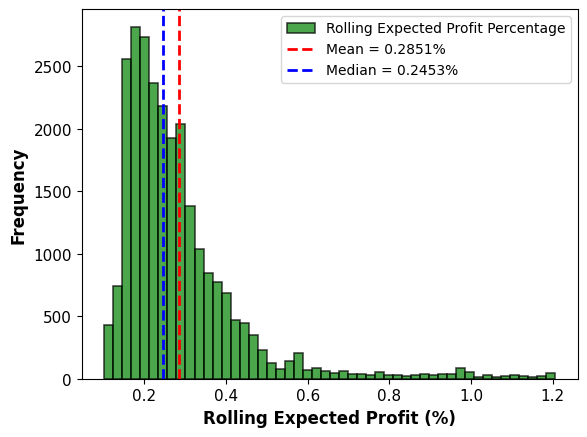

In [263]:
rolling_std_no_nan = rolling_std_test.dropna()

s1_rolling = S1_test[rolling_std_no_nan.index]
s2_rolling = S2_test[rolling_std_no_nan.index]
beta_rolling = beta_series_test[rolling_std_no_nan.index]
beta_rolling = np.abs(beta_rolling)  # Ensure beta is non-negative

rolling_expected_profit_percentage = rolling_std_no_nan / (s1_rolling + beta_rolling * s2_rolling)
rolling_expected_profit_percentage = rolling_expected_profit_percentage * 100  # Convert to percentage

plt.hist(rolling_expected_profit_percentage, bins = 50, alpha=0.7, color='green', edgecolor='black', linewidth=1.2, label='Rolling Expected Profit Percentage')
plt.axvline(rolling_expected_profit_percentage.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean = {rolling_expected_profit_percentage.mean():.4f}%')

plt.axvline(np.median(rolling_expected_profit_percentage), color='blue', linestyle='--', linewidth=2,
            label=f'Median = {np.median(rolling_expected_profit_percentage):.4f}%')

plt.xlabel('Rolling Expected Profit (%)', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend()

#Save the plot as a high-resolution PNG file
file_path =  f'results/reinforcement_learning/{sym1_train}_{sym2_train}/rolling_expected_profit_distribution_{sym1_train}_{sym2_train}.png'

os.makedirs(os.path.dirname(file_path), exist_ok=True)  # Ensure the directory exists
plt.savefig(file_path, dpi=300, bbox_inches='tight')


plt.show()


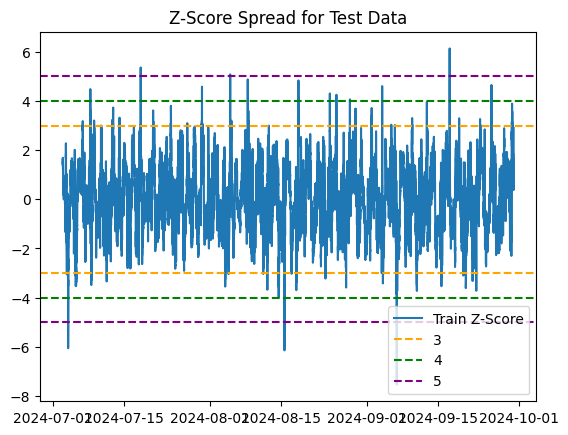

In [264]:
plt.plot(zscore_series_test, label='Train Z-Score')
plt.axhline(3, color='orange', linestyle='--', label='3')
plt.axhline(-3, color='orange', linestyle='--')
plt.axhline(4, color='g', linestyle='--', label='4')
plt.axhline(-4, color='g', linestyle='--',)
plt.axhline(5, color='purple', linestyle='--', label='5')
plt.axhline(-5, color='purple', linestyle='--')
plt.title('Z-Score Spread for Test Data')
plt.legend()

---

# Train agent
---

In [265]:

print("Training DQN agent...")
# Define your discrete threshold pairs: [(entry1, stop1), (entry2, stop2), ...]
entry_stop_pairs = [(1, 2), (2, 3),(3, 4),(4,5)]

# Training parameters
initial_capital = 10_000
tx_cost = 0

#Hyperparameters
num_epochs = 150 #Best was 150 for FLOWUSDT_2024_5m ~ MANAUSDT_2024_5m
batch_size = 32
gamma = 0.99
lr = 0.001
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
replay_capacity = 1000
target_update_freq = 10
hidden_dim = 64
tau = 0.01  # Soft update parameter for target network

online_net, replay_buffer,epoch_loss_history, reward_history,validation_reward_history,training_metrics = train_dqn(
                                                                                        zscore_series_train, 
                                                                                        prices_train, 
                                                                                        beta_series_train,
                                                                                        zscore_series_val,
                                                                                        prices_val,
                                                                                        beta_series_val,
                                                                                        initial_capital,
                                                                                        tx_cost,
                                                                                        entry_stop_pairs, 
                                                                                        num_epochs=num_epochs,
                                                                                        batch_size=batch_size,
                                                                                        gamma = gamma,
                                                                                        lr = lr,
                                                                                        epsilon_start = epsilon_start,
                                                                                        epsilon_end = epsilon_end,
                                                                                        epsilon_decay = epsilon_decay,
                                                                                        replay_capacity = replay_capacity,
                                                                                        target_update_freq = target_update_freq,
                                                                                        hidden_dim = hidden_dim,
                                                                                        tau= tau,                                           
                                                                                        )


Training DQN agent...
Number of cycles: 614
Epoch 01 | AvgReward: -0.55 | Epsilon: 0.995
Epoch 02 | AvgReward: -0.48 | Epsilon: 0.990
Epoch 03 | AvgReward: -0.46 | Epsilon: 0.985
Epoch 04 | AvgReward: -0.60 | Epsilon: 0.980
Epoch 05 | AvgReward: -0.49 | Epsilon: 0.975
Epoch 06 | AvgReward: -0.53 | Epsilon: 0.970
Epoch 07 | AvgReward: -0.53 | Epsilon: 0.966
Epoch 08 | AvgReward: -0.50 | Epsilon: 0.961
Epoch 09 | AvgReward: -0.48 | Epsilon: 0.956
Epoch 10 | AvgReward: -0.51 | Epsilon: 0.951
Epoch 11 | AvgReward: -0.47 | Epsilon: 0.946
Epoch 12 | AvgReward: -0.52 | Epsilon: 0.942
Epoch 13 | AvgReward: -0.52 | Epsilon: 0.937
Epoch 14 | AvgReward: -0.47 | Epsilon: 0.932
Epoch 15 | AvgReward: -0.42 | Epsilon: 0.928
Epoch 16 | AvgReward: -0.49 | Epsilon: 0.923
Epoch 17 | AvgReward: -0.44 | Epsilon: 0.918
Epoch 18 | AvgReward: -0.49 | Epsilon: 0.914
Epoch 19 | AvgReward: -0.42 | Epsilon: 0.909
Epoch 20 | AvgReward: -0.41 | Epsilon: 0.905
Epoch 21 | AvgReward: -0.47 | Epsilon: 0.900
Epoch 22 | 

# Save model & hyper params
---

In [198]:
hyper_parameters_df = pd.DataFrame({
    'num_epochs': [num_epochs],
    'batch_size': [batch_size],
    'gamma': [gamma],
    'lr': [lr],
    'epsilon_start': [epsilon_start],
    'epsilon_end': [epsilon_end],
    'epsilon_decay': [epsilon_decay],
    'replay_capacity': [replay_capacity],
    'target_update_freq': [target_update_freq],
    'hidden_dim': [hidden_dim],
    'tau': [tau]
})


# Save hyperparameters to a CSV file
#------------------------------------

hyper_params_file_path = f'results/reinforcement_learning/{sym1_test}_{sym2_test}/hyper_parameters_{sym1_test}_{sym2_test}.csv'

# Ensure the directory exists
if not os.path.exists(os.path.dirname(hyper_params_file_path)):
    os.makedirs(os.path.dirname(hyper_params_file_path))
hyper_parameters_df.to_csv(hyper_params_file_path, index=False)


#Save the model
#------------------------------------

model_file_path = f'results/reinforcement_learning/{sym1_test}_{sym2_test}/dqn_model_{sym1_test}_{sym2_test}.pth'

# Ensure the directory exists
if not os.path.exists(os.path.dirname(model_file_path)):
    os.makedirs(os.path.dirname(model_file_path))

# Save the model state dictionary
torch.save(online_net.state_dict(), model_file_path)

# Save the trained model
#torch.save(online_net.state_dict(), f'reinforcement_learning/{sym1_test}_{sym2_test}/dqn_model_{sym1_test}_{sym2_test}.pth')


NameError: name 'online_net' is not defined

# Parameter Optimization 
---

In [76]:
# n_trials = 5
# num_epochs = 200

# best_reward, best_params = optimize_hyperparameters(
#     zscore_series_train, prices_train, beta_series_train,
#     zscore_series_val,   prices_val,   beta_series_val,
#     initial_capital, tx_cost,
#     entry_stop_pairs,
#     n_trials,
#     num_epochs
# )

In [77]:
# lr_best, batch_size_best, hidden_dim_best, gamma_best, epsilon_decay_best, tau_best = best_params.values()

# print(f"Best reward: {best_reward}")
# print(f"Best hyperparameters: {best_params.values()}")
# # Train the DQN agent with the best hyperparameters

# #lr_best, batch_size_best, hidden_dim_best, gamma_best, epsilon_decay_best, tau_best = 0.00010366806196026195, 16, 32, 0.9811910981039401, 0.9906752554940417, 0.007164004897848127



In [78]:

# online_net, replay_buffer,epoch_loss_history, reward_history,validation_reward_history,training_metrics = train_dqn(
#                                                                                         zscore_series_train, 
#                                                                                         prices_train, 
#                                                                                         beta_series_train,
#                                                                                         zscore_series_val,
#                                                                                         prices_val,
#                                                                                         beta_series_val,
#                                                                                         initial_capital,
#                                                                                         tx_cost,
#                                                                                         entry_stop_pairs, 
#                                                                                         num_epochs=num_epochs,
#                                                                                         batch_size=batch_size_best,
#                                                                                         gamma = gamma_best,
#                                                                                         lr = lr_best,
#                                                                                         epsilon_start = 1,
#                                                                                         epsilon_end = 0.01,
#                                                                                         epsilon_decay = epsilon_decay_best,
#                                                                                         replay_capacity = 1000,
#                                                                                         target_update_freq = 10,
#                                                                                         hidden_dim = hidden_dim_best,
#                                                                                         tau= tau_best,                                           
#                                                                                         )

# # Save the trained model
# torch.save(online_net.state_dict(), 'dqn_model.pth')

In [79]:
# training_metrics_temp = training_metrics.copy()

In [80]:
# entry_stop_pairs_extended = [(1, 2), (2, 3),(3, 4),(4,5),(5,6),(6,7),(7,8),(8,9),(9,10)]

# Best thresholds
---

In [81]:
# env = PairsTradingEnv(zscore_series_train, prices_train, beta_series_train, initial_capital, tx_cost, entry_stop_pairs_extended, eval_mode=True) #keep eval_mode=True so no cylces are removed
# best_pairs_train = env.find_best_thresholds()
# spread_cycles_train = env.spread_cycles

# #best_pairs_train = find_best_thresholds(entry_stop_pairs,zscore_series_train,prices_train,beta_series_train)

# # Suppose best_pairs is your list of length N containing either (e,s) or None
# counts = Counter(best_pairs_train)   # Now counts[None] is how many cycles had no winning pair
# total  = len(best_pairs_train)

# # Convert raw counts to percentages
# pairs    = list(counts.keys())
# percent_train  = [counts[p] / total * 100 for p in pairs]

# # Turn None → a string label
# labels = [
#     "no winner" if p is None else f"{p[0]},{p[1]}"
#     for p in pairs
# ]

# zip_object = zip(labels, percent_train)

# print("Percentage Counts")
# print("---------------------")
# print(percent_train)

# print("Numerical counts")
# print("---------------------")
# print([counts[p] for p in pairs])


# # Plot
# plt.figure(figsize=(8,6))
# bars = plt.bar(range(len(labels)), percent_train, tick_label=labels)
# plt.ylabel("% of cycles")
# plt.xlabel("(entry, stop) pair")

# #Add value labels on top of the bars
# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', va='bottom')
# plt.xticks(rotation=45)
# plt.title("Best Entry–Stop Pair Coverage (Training set)")

# plt.tight_layout()





In [82]:
# env_val_best = PairsTradingEnv(zscore_series_val, prices_val, beta_series_val, initial_capital, tx_cost, entry_stop_pairs_extended, eval_mode=True)
# best_pairs_val = env_val_best.find_best_thresholds()
# spread_cycles_val = env_val_best.spread_cycles


# # Suppose best_pairs is your list of length N containing either (e,s) or None
# counts = Counter(best_pairs_val)   # Now counts[None] is how many cycles had no winning pair
# total  = len(best_pairs_val)

# # Convert raw counts to percentages
# pairs    = list(counts.keys())
# percent_val  = [counts[p] / total * 100 for p in pairs]

# # Turn None → a string label
# labels = [
#     "no winner" if p is None else f"{p[0]},{p[1]}"
#     for p in pairs
# ]

# print("Percentage Counts")
# print("---------------------")
# print(percent_val)


# print("Numerical counts")
# print("---------------------")
# print([counts[p] for p in pairs])



# # Plot
# plt.figure(figsize=(8,6))
# bars = plt.bar(range(len(labels)), percent_val, tick_label=labels)

# #Add percentage values on top of the bars
# for bar, percent in zip(bars, percent_val):
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{percent:.1f}%", ha='center', va='bottom')


# plt.ylabel("% of cycles")
# plt.xlabel("(entry, stop) pair")
# plt.title("Best Entry–Stop Pair Coverage (Validation set))")

In [83]:
# env_test_best = PairsTradingEnv(zscore_series_test, prices_test, beta_series_test, initial_capital, tx_cost, entry_stop_pairs_extended, eval_mode=True)
# best_pairs_test = env_test_best.find_best_thresholds()
# spread_cycles_test = env_test_best.spread_cycles


# # Suppose best_pairs is your list of length N containing either (e,s) or None
# counts = Counter(best_pairs_test)   # Now counts[None] is how many cycles had no winning pair
# total  = len(best_pairs_test)

# # Convert raw counts to percentages
# pairs    = list(counts.keys())
# percent_test  = [counts[p] / total * 100 for p in pairs]

# # Turn None → a string label
# labels = [
#     "no winner" if p is None else f"{p[0]},{p[1]}"
#     for p in pairs
# ]

# print("Percentage Counts")
# print("---------------------")
# print(percent_test)


# print("Numerical counts")
# print("---------------------")
# print([counts[p] for p in pairs])



# # Plot
# plt.figure(figsize=(8,6))
# bars = plt.bar(range(len(labels)), percent_test, tick_label=labels)
# plt.ylabel("% of cycles")
# plt.xlabel("(entry, stop) pair")

# #Add percentage text on top of each bar
# for bar, percent in zip(bars, percent_test):
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{percent:.1f}%", ha='center', va='bottom')
    
# plt.title("Best Entry–Stop Pair Coverage (Test set)")
# plt.tight_layout()




In [84]:
# plt.plot(zscore_series_train.iloc[0:420], color = 'grey', label='Z-Score Series')
# plt.plot(spread_cycles_train[0], color = 'r', label='Cycle 1')
# plt.plot(spread_cycles_train[1], color = 'b' , label='Cycle 2')
# plt.plot(spread_cycles_train[2], color = 'orange' , label='Cycle 3')
# plt.plot(spread_cycles_train[3], color = 'purple' , label='Cycle 4')
# plt.plot(spread_cycles_train[4], color = 'pink' , label='Cycle 5')
# plt.axhline(0, color = 'black', linestyle='--')
# plt.axhline(1, color = 'green', linestyle='--')
# plt.axhline(-1, color = 'green', linestyle='--')
# plt.legend(loc='lower left')
# plt.title('Z-Score Series with Cycles illustration (for training set)')

# Training performance
---

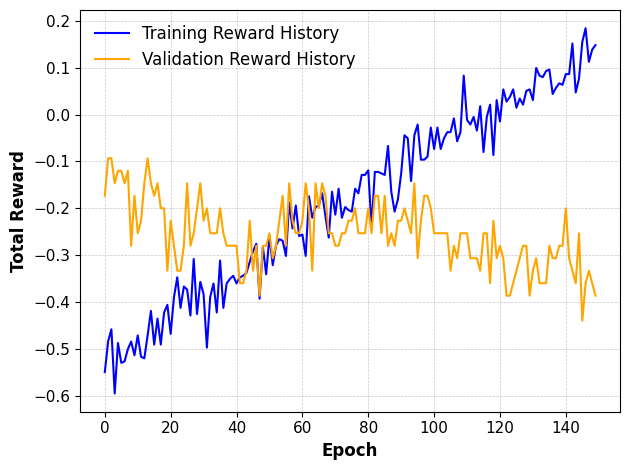

In [288]:

# Set figure size and dpi for sharpness
#plt.figure(figsize=(10, 4), dpi=300)

# Plot with thicker lines
plt.plot(reward_history, color='blue', label='Training Reward History', linewidth=1.5)
plt.plot(validation_reward_history, color='orange', label='Validation Reward History', linewidth=1.5)

# Add title with larger font
#plt.title('Training and Validation Reward During Training', fontsize=16, fontweight='bold')

# Add reference line with thicker line
#plt.axhline(0.2, color='black', linestyle='--', linewidth=1.5)

# Add axis labels with larger font
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Total Reward', fontsize=12, fontweight='bold')

# Customize tick parameters
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Add legend with larger font
plt.legend(fontsize=12, frameon=False)

# Add grid for readability (optional, remove if not wanted)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Tight layout to prevent clipping
plt.tight_layout()

#Save the plot

reward_curves_file_path = f'results/reinforcement_learning/{sym1_test}_{sym2_test}/reward_curves_{sym1_test}_{sym2_test}.png'

# Ensure the directory exists
if not os.path.exists(os.path.dirname(reward_curves_file_path)):
    os.makedirs(os.path.dirname(reward_curves_file_path))
plt.savefig(reward_curves_file_path, dpi=300)

# Show the plot
plt.show()



In [86]:
# def exponential_smooth(values, weight=0.9):
#     smoothed = [values[0]]
#     for val in values[1:]:
#         smoothed.append(weight * smoothed[-1] + (1 - weight) * val)
#     return smoothed

# smoothed_val_reward_history = exponential_smooth(validation_reward_history, weight=0.9)
# plt.plot(smoothed_val_reward_history, color='orange', label='Smoothed Validation Reward History')

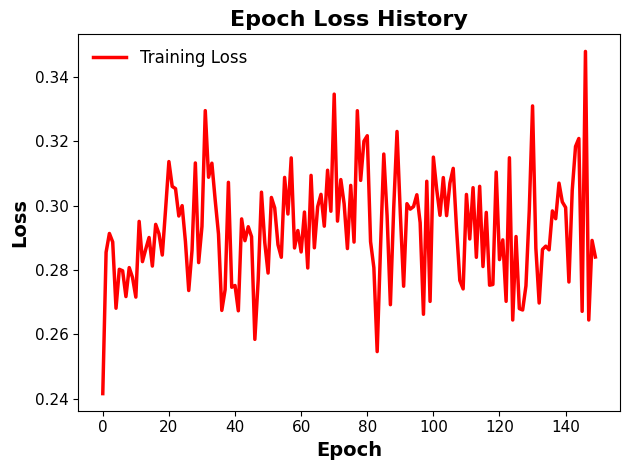

In [278]:

#plt.figure(figsize=(8, 6), dpi=300)

# Plot loss history with thicker line
plt.plot(epoch_loss_history, color='red', linewidth=2.5, label='Training Loss')

# Title and axis labels
plt.title('Epoch Loss History', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')

# Tick fonts
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Optional grid for clarity
#plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Optional: add legend (if useful for multi-line comparisons later)
plt.legend(fontsize=12, frameon=False)

# Tight layout
plt.tight_layout()

# Save the plot as a high-resolution PNG file
loss_history_file_path = f'results/reinforcement_learning/{sym1_test}_{sym2_test}/loss_history_{sym1_test}_{sym2_test}.png'
# Ensure the directory exists
if not os.path.exists(os.path.dirname(loss_history_file_path)):
    os.makedirs(os.path.dirname(loss_history_file_path))
plt.savefig(loss_history_file_path, dpi=300, bbox_inches='tight')

# Show plot
plt.show()


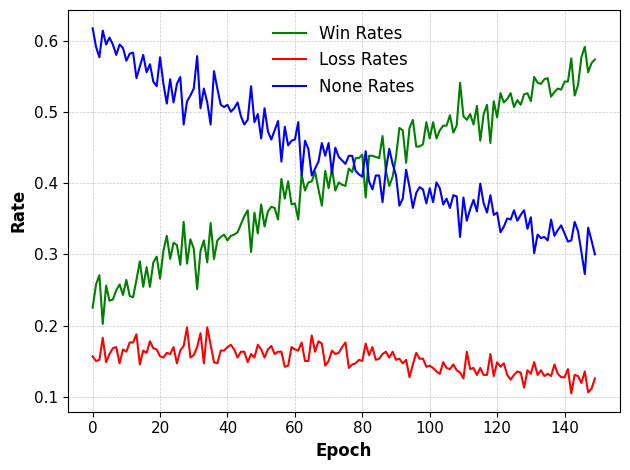

Final Training Metrics:
{'win_rate': 0.5742251223491027, 'loss_rate': 0.12561174551386622, 'forced_rate': 0.0, 'none_rate': 0.300163132137031}


In [287]:
win_rates = training_metrics['win_rates']
loss_rates = training_metrics['loss_rates']
forced_rates = training_metrics['forced_rates']
none_rates = training_metrics['no_trade_rates']

# print("Final win rates: ", win_rates[-1])
# print("Final loss rates: ", loss_rates[-1])
# print("Final forced rates: ", forced_rates[-1])
# print("Final none rates: ", none_rates[-1])

training_metrics_final = {'win_rate': win_rates[-1],
                                 'loss_rate': loss_rates[-1],
                                 'forced_rate': forced_rates[-1],
                                 'none_rate': none_rates[-1]}


# Plot each metric with thicker lines
plt.plot(win_rates, color='green', linewidth=1.5, label='Win Rates')
plt.plot(loss_rates, color='red', linewidth=1.5, label='Loss Rates')
# plt.plot(forced_rates, color='orange', linewidth=2.5, label='Forced Rates')  # Optional
plt.plot(none_rates, color='blue', linewidth=1.5, label='None Rates')

# Title and axis labels
#plt.title('Training Metrics Over Epochs', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Rate', fontsize=12, fontweight='bold')

# Tick fonts
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Legend styling
plt.legend(fontsize=12, frameon=False)

# Optional grid for readability
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Tight layout
plt.tight_layout()

plt.savefig(f'results/reinforcement_learning/{sym1_test}_{sym2_test}/training_metrics_{sym1_test}_{sym2_test}.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


# Save training metrics to a CSV file
training_metrics_df = pd.DataFrame([training_metrics_final])
training_metrics_file_path = f'results/reinforcement_learning/{sym1_test}_{sym2_test}/training_metrics_{sym1_test}_{sym2_test}.csv'
# Ensure the directory exists
if not os.path.exists(os.path.dirname(training_metrics_file_path)):
    os.makedirs(os.path.dirname(training_metrics_file_path))
training_metrics_df.to_csv(training_metrics_file_path, index=False)

# Print the final training metrics
print("Final Training Metrics:")
print(training_metrics_final)


In [89]:
# best_trial, study = optimize_hyperparameters(
#     zscore_series_train, prices_train, beta_series_train,
#     zscore_series_val,   prices_val,   beta_series_val,
#     initial_capital, tx_cost,
#     entry_stop_pairs,
#     n_trials=50
# )

# Evaluate
---

In [138]:
#Recreate the model and load the saved state_dict
#online_net_trained = DQN(input_dim=7, output_dim=len(entry_stop_pairs), hidden_dim=hidden_dim_best)# Load the saved state_dict into the model
online_net_trained = DQN(input_dim=7, output_dim=len(entry_stop_pairs), hidden_dim=64)# Load the saved state_dict into the model


# online_net_trained.load_state_dict(torch.load('dqn_model.pth'))
# print("LOADED BEST HYPERPARAMS MODEL")


# # Load the saved state_dict for sym1_test and sym2_test

file_path = f'results/reinforcement_learning/{sym1_test}_{sym2_test}/dqn_model_{sym1_test}_{sym2_test}.pth'

if os.path.exists(file_path):
    print(f"Loading model from {file_path}")
    online_net_trained.load_state_dict(torch.load(file_path))
    print("Model loaded successfully ✅")
else:
    print(f"Model file {file_path} does not exist. Please check the path.")
    raise FileNotFoundError(f"Model file {file_path} not found.")





Loading model from results/reinforcement_learning/AXSUSDT_2024_5m_MANAUSDT_2024_5m/dqn_model_AXSUSDT_2024_5m_MANAUSDT_2024_5m.pth
Model loaded successfully ✅


In [139]:
tx_cost = 0.000

#define test environment
env_test = PairsTradingEnv(zscore_series_test, prices_test, beta_series_test, initial_capital, tx_cost, entry_stop_pairs, eval_mode=True)

#TEST SET
test_rewards,trade_profits_agent,actions,episodes,test_metrics = evaluate_dqn(
    env_test,
    online_net_trained,
    entry_stop_pairs,
)
print(test_metrics)

# Save the test metrics to a CSV file
test_metrics_df = pd.DataFrame(test_metrics, index=[0])
test_metrics_file_path = f'results/reinforcement_learning/{sym1_test}_{sym2_test}/test_metrics_{sym1_test}_{sym2_test}.csv'
# Ensure the directory exists
if not os.path.exists(os.path.dirname(test_metrics_file_path)):
    os.makedirs(os.path.dirname(test_metrics_file_path))
test_metrics_df.to_csv(test_metrics_file_path, index=False)

#TRAINING SET

# test_rewards,trade_profits,actions,episodes,test_metrics = evaluate_dqn(
#     online_net_trained,
#     zscore_series_train,
#     prices_train,
#     beta_series_train,
#     initial_capital,
#     tx_cost,
#     entry_stop_pairs,
# )
# print(test_metrics)

#VALIDATION SET

# test_rewards,trade_profits,actions,episodes,test_metrics = evaluate_dqn(
#     online_net_trained,
#     zscore_series_val,
#     prices_val,
#     beta_series_val,
#     initial_capital,
#     tx_cost,
#     entry_stop_pairs,
# )
# print(test_metrics)



{'avg_reward': np.float64(-0.0935672514619883), 'win_rate': 0.45321637426900585, 'loss_rate': 0.30409356725146197, 'forced_rate': 0.0, 'no_trade_rate': 0.24269005847953215}


In [140]:

# tx_cost_lista = [0.0000,0.005]

# for tx_cost in tx_cost_lista:

#     env_test = PairsTradingEnv(zscore_series_test, prices_test, beta_series_test, initial_capital, tx_cost, entry_stop_pairs, eval_mode=True)

#     #TEST SET
#     test_rewards,trade_profits_agent,actions,episodes,test_metrics = evaluate_dqn(
#         env_test,
#         online_net_trained,
#         entry_stop_pairs,
#     )

#     print('tx_cost:', tx_cost)
#     print('Trade profits:', trade_profits_agent)
    
#     plt.plot(trade_profits_agent)
#     plt.title('Trade Profits Agent')
#     plt.xlabel('Trade Number')
#     plt.ylabel('Trade Profit')

    

# Gather stats for agent wins, losses and misses
---

In [141]:
num_cycles_test = len(env_test.spread_cycles)

print(f"Number of cycles in test set: {num_cycles_test}")

#Filter for trades that actually got executed (i.e., profits != 0)
actual_trade_profits_agent = [profit for profit in trade_profits_agent if profit != 0]


agent_wins = 0
agent_losses = 0
agent_misses = 0

for episode in episodes:

    exit = episode['exit_meta']

    if exit is not None:
        exit_type = exit['exit_type']

        if exit_type == 'win':
            agent_wins += 1
        elif exit_type == 'loss':
            agent_losses += 1
    else:
        agent_misses += 1

print(f"Agent Wins: {agent_wins}, Losses: {agent_losses}, Misses: {agent_misses}")

Number of cycles in test set: 343
Agent Wins: 155, Losses: 104, Misses: 83


# Gather other metrics and compare with fixed thresholds
---

In [142]:
actions_profits_list = zip(actions,trade_profits_agent)
actions_profits_df = pd.DataFrame(actions_profits_list, columns=['Actions', 'Trade Profits'])

#Show all rows
# pd.set_option('display.max_rows', None)=
# pd.set_option('display.max_columns', None)

# actions_profits_df_zeros = actions_profits_df[actions_profits_df['Trade Profits'] > 0]
#actions_profits_df_zeros

actions_profits_df_three_four = actions_profits_df[actions_profits_df['Actions'] == (1, 2)]
actions_profits_df_three_four.head(50)

,Actions,Trade Profits
0,"(1, 2)",-65.298251
1,"(1, 2)",-34.820839
2,"(1, 2)",83.639623
5,"(1, 2)",-143.677431
6,"(1, 2)",-16.587561
8,"(1, 2)",133.637913
10,"(1, 2)",685.410350
11,"(1, 2)",77.628540
12,"(1, 2)",88.101235
15,"(1, 2)",-40.918765


In [143]:
profits_absolute = np.abs(np.array(trade_profits_agent))
print(f"Average absolute profit per trade: {np.mean(profits_absolute):.4f}")

Average absolute profit per trade: 54.2733


Action (1, 2): 59.65%
Action (2, 3): 33.33%
Action (3, 4): 6.43%
Action (4, 5): 0.58%


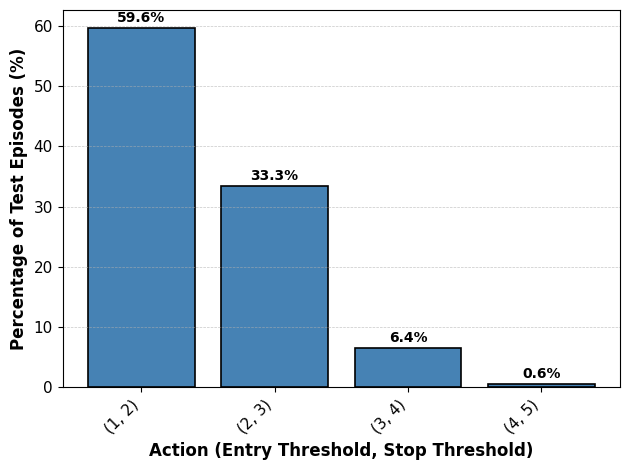

In [305]:


# 1. Count how many times each action appears
counts = Counter(actions)
total = len(actions)

# 2. Compute percentages
actions_sorted = sorted(counts.keys())
percentages = [counts[a] / total * 100 for a in actions_sorted]

# Optional: print summary
actions_percentages_zip = zip(actions_sorted, percentages)
for action, percentage in actions_percentages_zip:
    print(f"Action {action}: {percentage:.2f}%")

# 3. Plot the distribution
#plt.figure(figsize=(8, 6), dpi=300)

# Bar plot with edgecolor
bars = plt.bar(range(len(actions_sorted)), percentages, color='steelblue', edgecolor='black', linewidth=1.2)

# X-ticks (rotated for readability)
plt.xticks(range(len(actions_sorted)), [f"{a}" for a in actions_sorted], fontsize=11, rotation=45, ha='right')

# Axis labels (large and bold)
plt.xlabel("Action (Entry Threshold, Stop Threshold)", fontsize=12, fontweight='bold')
plt.ylabel("Percentage of Test Episodes (%)", fontsize=12, fontweight='bold')

# Title (large and bold)
#plt.title("Distribution of Actions Taken on Test Set", fontsize=16, fontweight='bold')

# Y-tick font size
plt.yticks(fontsize=11)


# Optional: add grid
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Add % labels on top of each bar
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{pct:.1f}%', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Tight layout
plt.tight_layout()


# Save the plot as a high-resolution PNG file
file_path = f'results/reinforcement_learning/{sym1_test}_{sym2_test}/actions_distribution_{sym1_test}_{sym2_test}.png'
os.makedirs(os.path.dirname(file_path), exist_ok=True)  # Ensure the directory exists
plt.savefig(file_path, dpi=300, bbox_inches='tight')

# Show plot
plt.show()


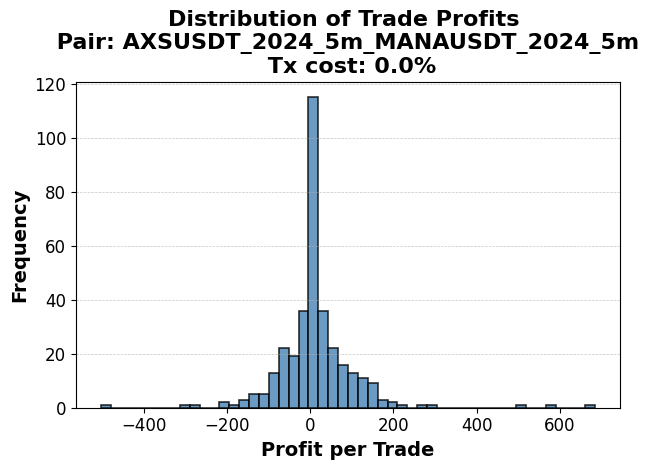

In [145]:

#plt.figure(figsize=(8, 6), dpi=300)

# Plot histogram with clear styling
plt.hist(trade_profits_agent, bins=50, color='steelblue', edgecolor='black', linewidth=1.2, alpha=0.8)

# Title and axis labels
plt.title(f'Distribution of Trade Profits \n Pair: {sym1_test}_{sym2_test} \n Tx cost: {tx_cost*100}%', fontsize=16, fontweight='bold')
plt.xlabel('Profit per Trade', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# Tick fonts
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Optional: grid on y-axis
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Tight layout for clean margins
plt.tight_layout()

if tx_cost == 0:

    # Save the plot as a high-resolution PNG file
    file_path = f'results/reinforcement_learning/{sym1_test}_{sym2_test}/trade_profits_distribution_no_tx_{sym1_test}_{sym2_test}.png'
    os.makedirs(os.path.dirname(file_path), exist_ok=True)  # Ensure the directory exists
else:
    # Save the plot as a high-resolution PNG file
    file_path = f'results/reinforcement_learning/{sym1_test}_{sym2_test}/trade_profits_distribution_with_tx_{sym1_test}_{sym2_test}.png'
    os.makedirs(os.path.dirname(file_path), exist_ok=True)



plt.savefig(file_path, dpi=300, bbox_inches='tight')

# Show plot
plt.show()


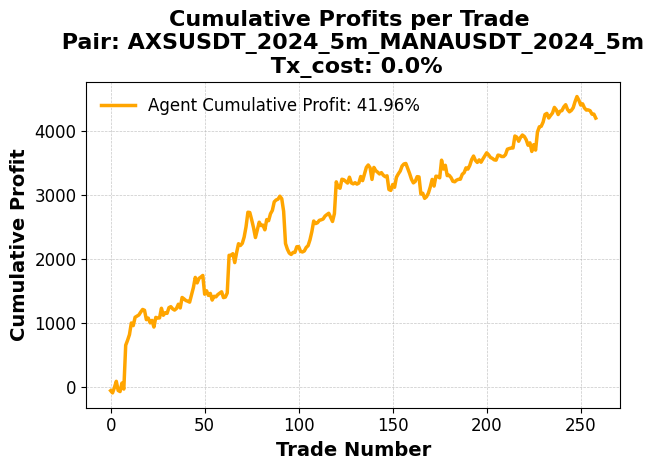

In [146]:

# 1. Compute cumulative profits
trade_profits_cumulative_agent = np.cumsum(actual_trade_profits_agent)

# 2. Compute and print final return
final_return_test_set = (trade_profits_cumulative_agent[-1] / initial_capital) * 100
#print("Final returns: ", final_return_test_set, "%")

# 3. Plot
#plt.figure(figsize=(8, 6), dpi=300)

# Plot cumulative profit line (bold, clear)
plt.plot(trade_profits_cumulative_agent, color='orange', linewidth=2.5, label= f'Agent Cumulative Profit: {final_return_test_set:.2f}%')

# Title and axis labels
plt.title(f'Cumulative Profits per Trade \n Pair: {sym1_test}_{sym2_test} \n Tx_cost: {tx_cost*100}%', fontsize=16, fontweight='bold')
plt.xlabel('Trade Number', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Profit', fontsize=14, fontweight='bold')

# Tick fonts
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Optional grid for clarity
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# # Optional: add final return as text on the plot
# plt.text(len(trade_profits_cumulative_agent) * 0.95, 
#          trade_profits_cumulative_agent[-1] * 0.98,
#          f'Final Return: {final_return_test_set:.2f}%',
#          fontsize=12, fontweight='bold', ha='right', color='orange')

# Optional: add legend
plt.legend(fontsize=12, frameon=False)

# Tight layout for clean margins
plt.tight_layout()

if tx_cost == 0:
    # Save the plot as a high-resolution PNG file
    file_path = f'results/reinforcement_learning/{sym1_test}_{sym2_test}/normal_cumulative_profits_no_tx_{sym1_test}_{sym2_test}.png'
    os.makedirs(os.path.dirname(file_path), exist_ok=True)  # Ensure the directory exists
else:
    # Save the plot as a high-resolution PNG file
    file_path = f'results/reinforcement_learning/{sym1_test}_{sym2_test}/normal_cumulative_profits_with_tx_{sym1_test}_{sym2_test}.png'
    os.makedirs(os.path.dirname(file_path), exist_ok=True)


plt.savefig(file_path, dpi=300, bbox_inches='tight')

# Show plot
plt.show()


In [147]:
# risk_free_rate = 0.0  # Assuming no risk-free rate for simplicity
# sharpe_ratio_agent = compute_sharpe_ratio(initial_capital,actual_trade_profits_agent,risk_free_rate)
# #sortino_ratio_agent = compute_sortino_ratio(initial_capital, actual_trade_profits_agent, risk_free_rate)    
# print("Sharpe Ratio agent: ", sharpe_ratio_agent)
# #print("Sortino Ratio agent: ", sortino_ratio_agent)


In [148]:
#Extract exit times from episodes

agent_trade_exit_times = []

for episode in episodes:

    if tx_cost == 0:   

        if episode['exit_meta'] is not None and episode['exit_meta']['exit_type'] != 'forced_exit':
            exit_time = episode['exit_meta']['time']
            agent_trade_exit_times.append(exit_time)
    else:
        if episode['exit_meta'] is not None:
            exit_time = episode['exit_meta']['time']
            agent_trade_exit_times.append(exit_time)


print(len(agent_trade_exit_times))


cumulative_profit_series_agent = pd.Series(trade_profits_cumulative_agent, index=agent_trade_exit_times)

# Calculate the maximum drawdown
max_drawdown_agent = compute_max_drawdown(initial_capital,cumulative_profit_series_agent)
print("Maximum Drawdown: ", max_drawdown_agent, "%")




cumulative_profit_series_agent = cumulative_profit_series_agent.reindex(prices_test.index, method='ffill').fillna(0)
cumulative_profit_series_agent

259
Maximum Drawdown:  7.021413451061745 %


timestamp
2024-07-03 00:00:00       0.000000
2024-07-03 00:05:00       0.000000
2024-07-03 00:10:00       0.000000
2024-07-03 00:15:00       0.000000
2024-07-03 00:20:00       0.000000
                          ...     
2024-09-29 23:35:00    4196.160327
2024-09-29 23:40:00    4196.160327
2024-09-29 23:45:00    4196.160327
2024-09-29 23:50:00    4196.160327
2024-09-29 23:55:00    4196.160327
Length: 25621, dtype: float64

In [149]:
# #Gather exit times for each trade from episodes

# trade_exit_times = []

# for episode in episodes:

#     if(episode['exit_meta'] is not None):
#         exit_time = episode['exit_meta']['time']

#         trade_exit_times.append(exit_time)

# trade_profits_np = np.array(actual_trade_profits_agent)
# trade_returns = trade_profits_np/ initial_capital * 100  # Convert to percentage returns
# test_set_times = prices_test.index

# annualized_sharpe = compute_annualized_sharpe_ratio(trade_returns,trade_exit_times,test_set_times, risk_free_rate)
# annualized_sharpe

Number of trades in best possible strategy: 342


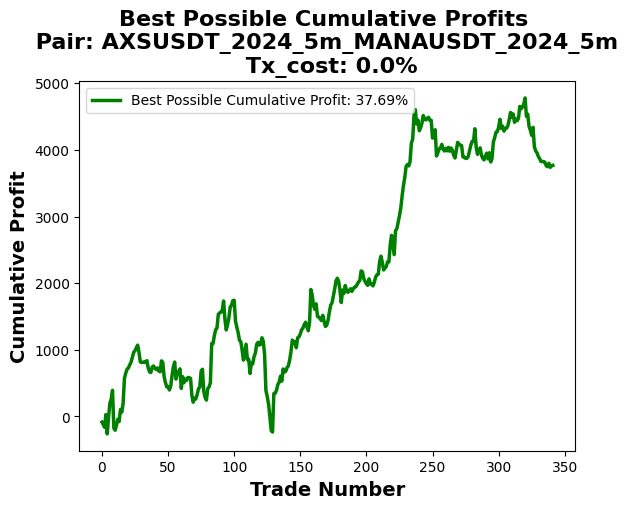

In [150]:
#Plot best possible equity curve


best_actions = env_test.best_pairs

best_actions_skip_first = best_actions[1:]  # Skip the first action since the agent only acts after the first observation

zscore_trade_cycles = env_test.spread_cycles[1:]
prices_trade_cycles = env_test.price_cycles[1:]
beta_trade_cycles = env_test.beta_cycles[1:]

best_trade_profits = []

for index,best_action in enumerate(best_actions_skip_first):
    
    entry, stop = best_action

    zscore_trading_cycle = zscore_trade_cycles[index]
    prices_trade_cycle = prices_trade_cycles[index]
    beta_trading_cycle = beta_trade_cycles[index]


    # 1) peel off S1/S2 series
    sym1, sym2 = prices_trade_cycle.columns
    S1 = prices_trade_cycle[sym1]
    S2 = prices_trade_cycle[sym2]

    # 2) backtest, get all entry/exit events in this window
    positions, trade_entries, trade_exits = backtest_pair_rolling(
        S1=S1,
        S2=S2,
        zscore=zscore_trading_cycle,
        entry_threshold=entry,
        exit_threshold=0.0,     # mean-reversion
        stop_loss_threshold=stop,
        agent_trader=True
    )

    # 4) focus on the *first* trade
    entry_meta = trade_entries[0]
    exit_meta  = trade_exits[0]

    # 5) compute the P&L of that one trade (for logging only)
    #    simulate_strategy_trade_pnl expects lists of entries/exits:
    pnl_list, _, _, _, _, _ = simulate_strategy_trade_pnl(
        [entry_meta], [exit_meta],
        initial_capital, beta_trading_cycle, tx_cost
    )

    profit = pnl_list[0]
    best_trade_profits.append(profit)

best_trade_profits_cumulative = np.cumsum(best_trade_profits)
print(f"Number of trades in best possible strategy: {len(best_trade_profits)}")

plt.plot(best_trade_profits_cumulative, color='green', linewidth=2.5, label= f'Best Possible Cumulative Profit: {(best_trade_profits_cumulative[-1] / initial_capital) * 100:.2f}%')
# Title and axis labels
plt.title(f'Best Possible Cumulative Profits \n Pair: {sym1_test}_{sym2_test} \n Tx_cost: {tx_cost*100}%', fontsize=16, fontweight='bold')
plt.xlabel('Trade Number', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Profit', fontsize=14, fontweight='bold')
plt.legend()
plt.show()

In [151]:
best_actions_skip_first

[(2, 3),
 (1, 2),
 (3, 4),
 (6, 7),
 (1, 2),
 (2, 3),
 (2, 3),
 (1, 2),
 (1, 2),
 (3, 4),
 (3, 4),
 (1, 2),
 (1, 2),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (4, 5),
 (1, 2),
 (1, 2),
 (3, 4),
 (3, 4),
 (2, 3),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (3, 4),
 (2, 3),
 (2, 3),
 (1, 2),
 (3, 4),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (3, 4),
 (2, 3),
 (1, 2),
 (2, 3),
 (2, 3),
 (1, 2),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (2, 3),
 (1, 2),
 (2, 3),
 (5, 6),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (3, 4),
 (2, 3),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (3, 4),
 (1, 2),
 (1, 2),
 (2, 3),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (2, 3),
 (2, 3),
 (2, 3),
 (3, 4),
 (1, 2),
 (1, 2),
 (2, 3),
 (1, 2),
 (2, 3),
 (1, 2),
 (4, 5),
 (1, 2),
 (2, 3),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (2, 3),
 

(array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  1.,  5.,
         3.,  1.,  4.,  5.,  5.,  6.,  8., 14., 17., 25., 26., 33., 42.,
        35., 25., 26., 17.,  8.,  9.,  9.,  2.,  1.,  3.,  1.,  0.,  0.,
         0.,  3.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.]),
 array([-568.01544509, -544.86084498, -521.70624488, -498.55164477,
        -475.39704466, -452.24244456, -429.08784445, -405.93324434,
        -382.77864424, -359.62404413, -336.46944403, -313.31484392,
        -290.16024381, -267.00564371, -243.8510436 , -220.69644349,
        -197.54184339, -174.38724328, -151.23264317, -128.07804307,
        -104.92344296,  -81.76884286,  -58.61424275,  -35.45964264,
         -12.30504254,   10.84955757,   34.00415768,   57.15875778,
          80.31335789,  103.46795799,  126.6225581 ,  149.77715821,
         172.93175831,  196.08635842,  219.24095853,  242.39555863,
         265.55015874,  288.70475885,  311.85935895,  335.01395906,
         358.16855916,  381.32315927

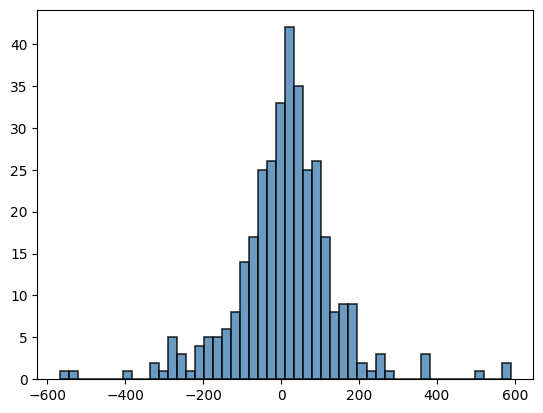

In [152]:
plt.hist(best_trade_profits, bins=50, color='steelblue', edgecolor='black', linewidth=1.2, alpha=0.8)

In [153]:
prices_trade_cycles

[                     AXSUSDT_2024_5m  MANAUSDT_2024_5m
 timestamp                                             
 2024-07-03 14:05:00            5.880            0.3350
 2024-07-03 14:10:00            5.871            0.3348
 2024-07-03 14:15:00            5.902            0.3355
 2024-07-03 14:20:00            5.900            0.3350
 2024-07-03 14:25:00            5.886            0.3345
 2024-07-03 14:30:00            5.885            0.3346
 2024-07-03 14:35:00            5.880            0.3338
 2024-07-03 14:40:00            5.885            0.3335
 2024-07-03 14:45:00            5.891            0.3333
 2024-07-03 14:50:00            5.894            0.3327
 2024-07-03 14:55:00            5.880            0.3328
 2024-07-03 15:00:00            5.856            0.3313
 2024-07-03 15:05:00            5.865            0.3320
 2024-07-03 15:10:00            5.882            0.3324
 2024-07-03 15:15:00            5.880            0.3321
 2024-07-03 15:20:00            5.895           

# Compare single threshold strategy to agent


In [154]:
# entry_threshold = 1
# exit_threshold = 0.0
# stop_loss_threshold = 2

# tx_cost = 0


# #No agent
# #-------
# positions, trade_entries, trade_exits = backtest_pair_rolling(S1_test, S2_test, zscore_series_test,
#                                                             entry_threshold, exit_threshold, stop_loss_threshold)
# trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent, \
#     cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = \
#     simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_test, tx_cost)

# #Agent
# #-------
# env_test = PairsTradingEnv(zscore_series_test, prices_test, beta_series_test, initial_capital, tx_cost, entry_stop_pairs, eval_mode=True)

# test_rewards,trade_profits_agent,actions,episodes,test_metrics = evaluate_dqn(
#     env_test,
#     online_net_trained,
#     entry_stop_pairs,
# )

# agent_trade_exit_times = []

# for episode in episodes:

#     if tx_cost == 0:   
    
#         if episode['exit_meta'] is not None and episode['exit_meta']['exit_type'] != 'forced_exit':
#             exit_time = episode['exit_meta']['time']
#             agent_trade_exit_times.append(exit_time)
#     else:
#         if episode['exit_meta'] is not None:
#             exit_time = episode['exit_meta']['time']
#             agent_trade_exit_times.append(exit_time)



# #Find common trade exit times between agent and no agent
# common_exit_times = set(agent_trade_exit_times) & set(exit_times_no_agent)
# # Create a DataFrame for the common exit times
# common_exit_times_df = pd.DataFrame(list(common_exit_times), columns=['Exit Times'])


# for time in common_exit_times_df['Exit Times']:

#     for episode in episodes:
#         if episode['exit_meta'] is not None and episode['exit_meta']['time'] == time:
#             print(f"Entry threshold: {episode['entry_threshold']}, Stop threshold: {episode['stop_threshold']}, Exit type: {episode['exit_meta']['exit_type']}")
        



In [155]:
len(common_exit_times_df)

200

Total trades: 340
Wins: 192, Losses: 148, Forced Exits: 0
Win Rate: 56.47%
Loss Rate: 43.53%
Forced Exit Rate: 0.00%
Missed trades: 3
Number of trades:  340


/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_2860/1330705198.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Cumulative Return (%)': [(cumulative_profit_series_no_agent[-1] / initial_capital) * 100],
/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_2860/1330705198.py:109: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  returns_map[strategy_name] = (cumulative_profit_series_no_agent[-1] / initial_capital) * 100


Total trades: 151
Wins: 101, Losses: 50, Forced Exits: 0
Win Rate: 66.89%
Loss Rate: 33.11%
Forced Exit Rate: 0.00%
Missed trades: 192
Number of trades:  151
Total trades: 50
Wins: 37, Losses: 12, Forced Exits: 1
Win Rate: 74.00%
Loss Rate: 24.00%
Forced Exit Rate: 2.00%
Missed trades: 293
Number of trades:  50
Total trades: 11
Wins: 9, Losses: 2, Forced Exits: 0
Win Rate: 81.82%
Loss Rate: 18.18%
Forced Exit Rate: 0.00%
Missed trades: 332
Number of trades:  11


/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_2860/1330705198.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Cumulative Return (%)': [(cumulative_profit_series_agent[-1] / initial_capital) * 100],
/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_2860/1330705198.py:177: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  returns_map['Dynamic Agent'] = (cumulative_profit_series_agent[-1] / initial_capital) * 100


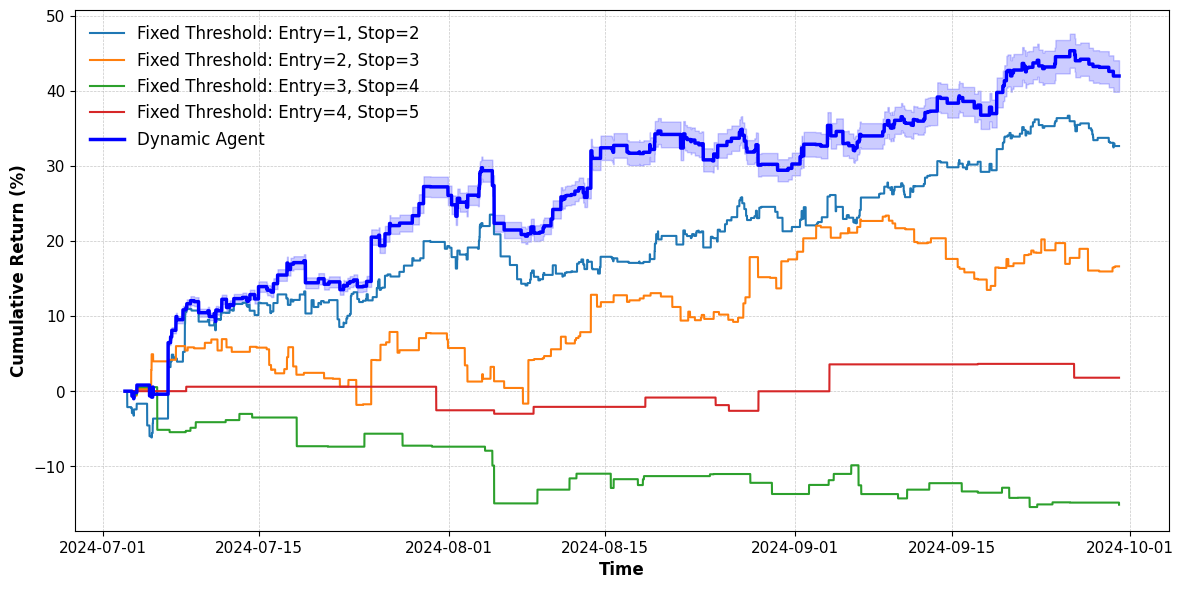

Total trades: 340
Wins: 192, Losses: 148, Forced Exits: 0
Win Rate: 56.47%
Loss Rate: 43.53%
Forced Exit Rate: 0.00%
Missed trades: 3
Number of trades:  340
Total trades: 151
Wins: 101, Losses: 50, Forced Exits: 0
Win Rate: 66.89%
Loss Rate: 33.11%
Forced Exit Rate: 0.00%
Missed trades: 192
Number of trades:  151
Total trades: 50
Wins: 37, Losses: 12, Forced Exits: 1
Win Rate: 74.00%
Loss Rate: 24.00%
Forced Exit Rate: 2.00%
Missed trades: 293
Number of trades:  50
Total trades: 11
Wins: 9, Losses: 2, Forced Exits: 0
Win Rate: 81.82%
Loss Rate: 18.18%
Forced Exit Rate: 0.00%
Missed trades: 332
Number of trades:  11


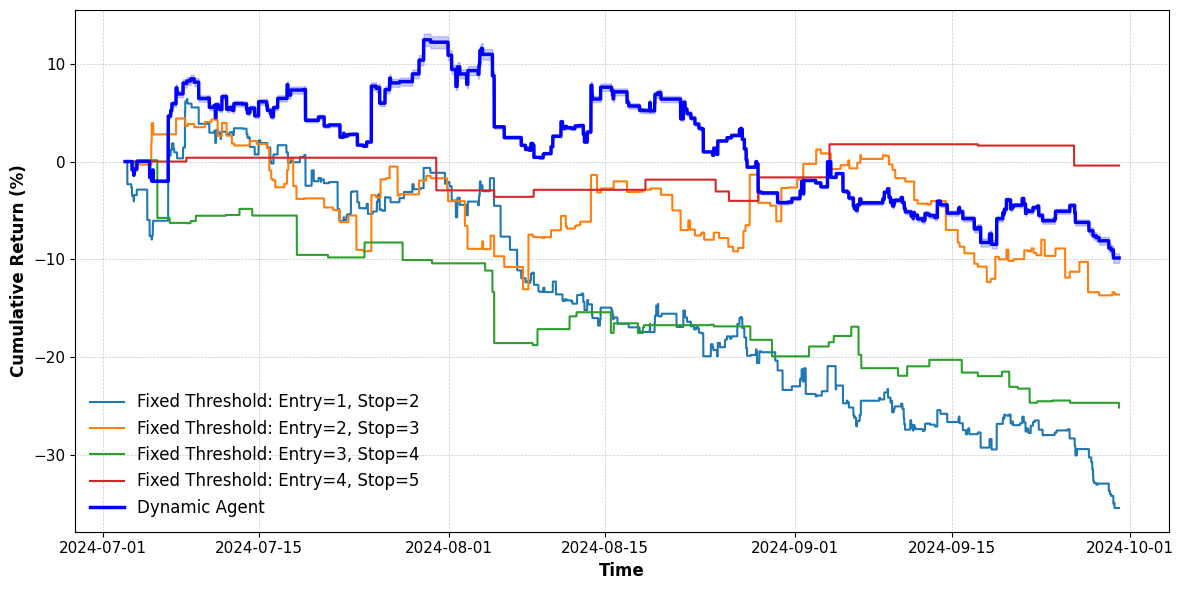

Total trades: 340
Wins: 192, Losses: 148, Forced Exits: 0
Win Rate: 56.47%
Loss Rate: 43.53%
Forced Exit Rate: 0.00%
Missed trades: 3
Number of trades:  340
Total trades: 151
Wins: 101, Losses: 50, Forced Exits: 0
Win Rate: 66.89%
Loss Rate: 33.11%
Forced Exit Rate: 0.00%
Missed trades: 192
Number of trades:  151
Total trades: 50
Wins: 37, Losses: 12, Forced Exits: 1
Win Rate: 74.00%
Loss Rate: 24.00%
Forced Exit Rate: 2.00%
Missed trades: 293
Number of trades:  50
Total trades: 11
Wins: 9, Losses: 2, Forced Exits: 0
Win Rate: 81.82%
Loss Rate: 18.18%
Forced Exit Rate: 0.00%
Missed trades: 332
Number of trades:  11


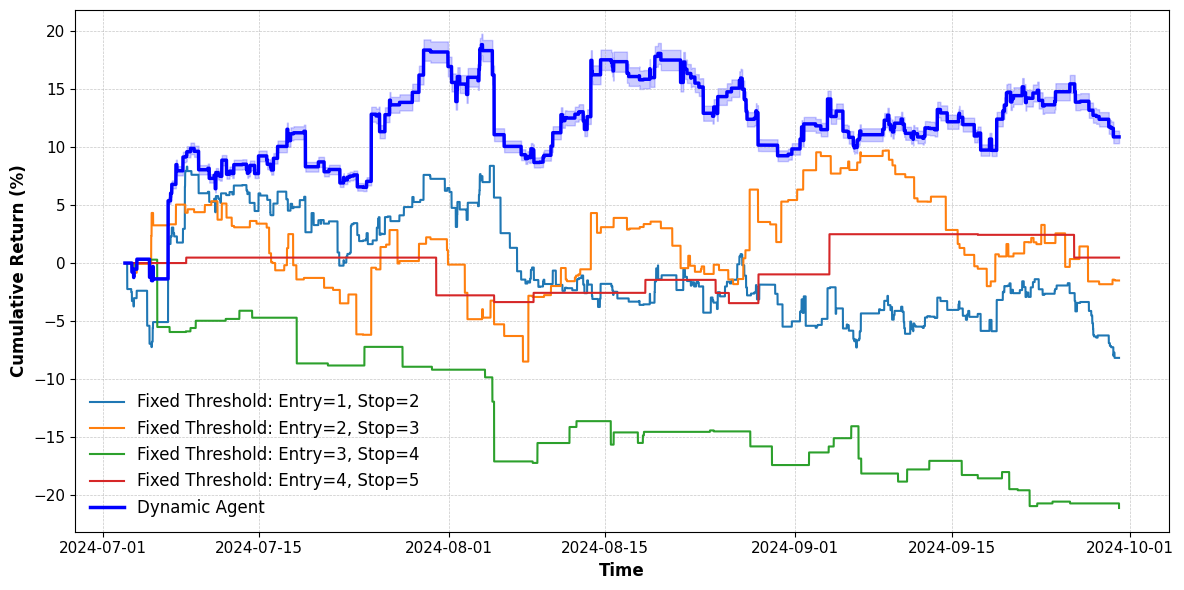

Total trades: 340
Wins: 192, Losses: 148, Forced Exits: 0
Win Rate: 56.47%
Loss Rate: 43.53%
Forced Exit Rate: 0.00%
Missed trades: 3
Number of trades:  340
Total trades: 151
Wins: 101, Losses: 50, Forced Exits: 0
Win Rate: 66.89%
Loss Rate: 33.11%
Forced Exit Rate: 0.00%
Missed trades: 192
Number of trades:  151
Total trades: 50
Wins: 37, Losses: 12, Forced Exits: 1
Win Rate: 74.00%
Loss Rate: 24.00%
Forced Exit Rate: 2.00%
Missed trades: 293
Number of trades:  50
Total trades: 11
Wins: 9, Losses: 2, Forced Exits: 0
Win Rate: 81.82%
Loss Rate: 18.18%
Forced Exit Rate: 0.00%
Missed trades: 332
Number of trades:  11


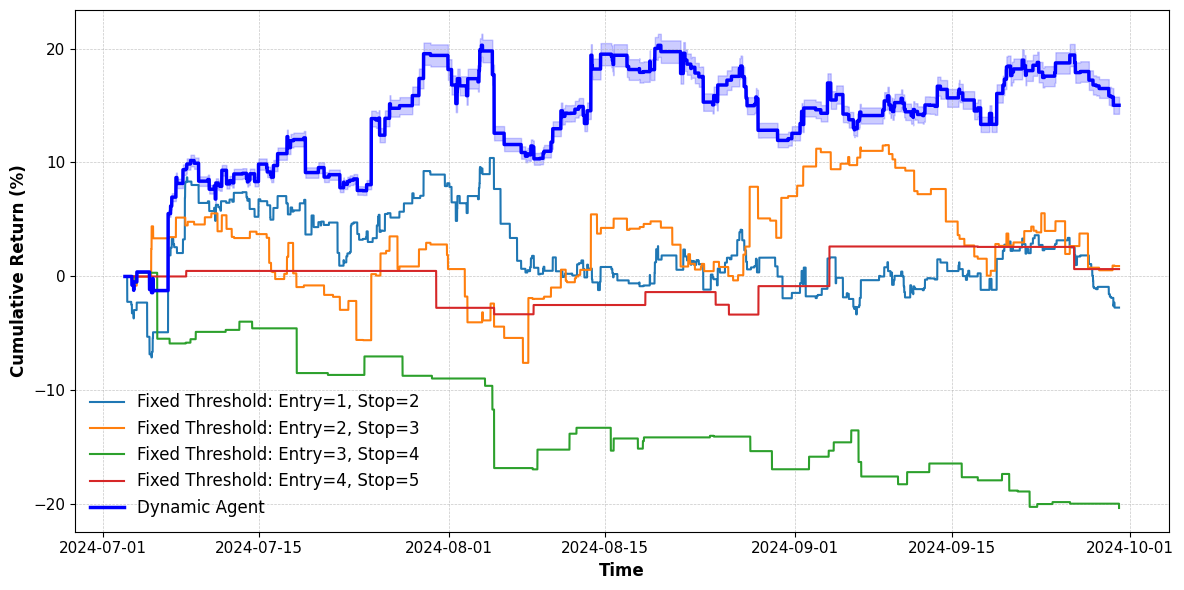

Total trades: 340
Wins: 192, Losses: 148, Forced Exits: 0
Win Rate: 56.47%
Loss Rate: 43.53%
Forced Exit Rate: 0.00%
Missed trades: 3
Number of trades:  340
Total trades: 151
Wins: 101, Losses: 50, Forced Exits: 0
Win Rate: 66.89%
Loss Rate: 33.11%
Forced Exit Rate: 0.00%
Missed trades: 192
Number of trades:  151
Total trades: 50
Wins: 37, Losses: 12, Forced Exits: 1
Win Rate: 74.00%
Loss Rate: 24.00%
Forced Exit Rate: 2.00%
Missed trades: 293
Number of trades:  50
Total trades: 11
Wins: 9, Losses: 2, Forced Exits: 0
Win Rate: 81.82%
Loss Rate: 18.18%
Forced Exit Rate: 0.00%
Missed trades: 332
Number of trades:  11


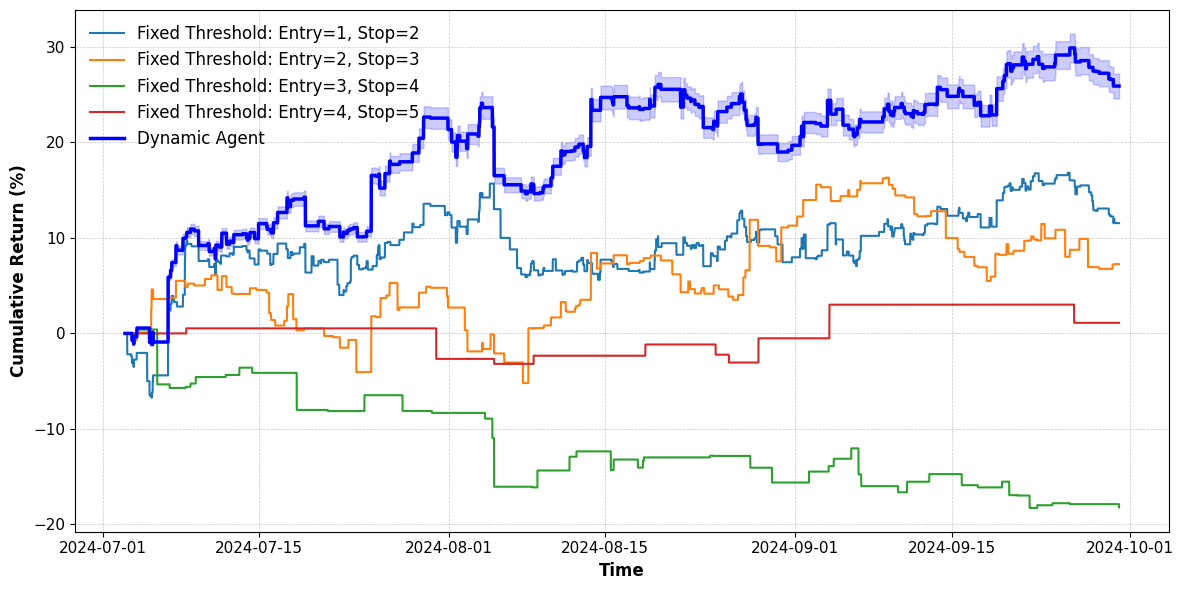

Total trades: 340
Wins: 192, Losses: 148, Forced Exits: 0
Win Rate: 56.47%
Loss Rate: 43.53%
Forced Exit Rate: 0.00%
Missed trades: 3
Number of trades:  340
Total trades: 151
Wins: 101, Losses: 50, Forced Exits: 0
Win Rate: 66.89%
Loss Rate: 33.11%
Forced Exit Rate: 0.00%
Missed trades: 192
Number of trades:  151
Total trades: 50
Wins: 37, Losses: 12, Forced Exits: 1
Win Rate: 74.00%
Loss Rate: 24.00%
Forced Exit Rate: 2.00%
Missed trades: 293
Number of trades:  50
Total trades: 11
Wins: 9, Losses: 2, Forced Exits: 0
Win Rate: 81.82%
Loss Rate: 18.18%
Forced Exit Rate: 0.00%
Missed trades: 332
Number of trades:  11


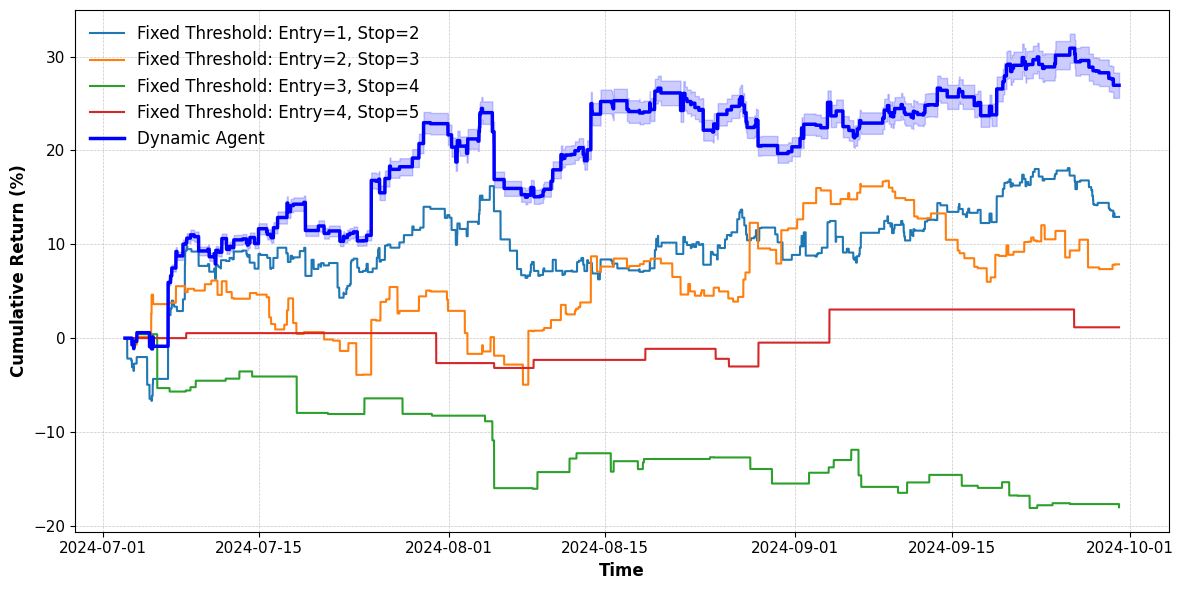

Total trades: 340
Wins: 192, Losses: 148, Forced Exits: 0
Win Rate: 56.47%
Loss Rate: 43.53%
Forced Exit Rate: 0.00%
Missed trades: 3
Number of trades:  340
Total trades: 151
Wins: 101, Losses: 50, Forced Exits: 0
Win Rate: 66.89%
Loss Rate: 33.11%
Forced Exit Rate: 0.00%
Missed trades: 192
Number of trades:  151
Total trades: 50
Wins: 37, Losses: 12, Forced Exits: 1
Win Rate: 74.00%
Loss Rate: 24.00%
Forced Exit Rate: 2.00%
Missed trades: 293
Number of trades:  50
Total trades: 11
Wins: 9, Losses: 2, Forced Exits: 0
Win Rate: 81.82%
Loss Rate: 18.18%
Forced Exit Rate: 0.00%
Missed trades: 332
Number of trades:  11


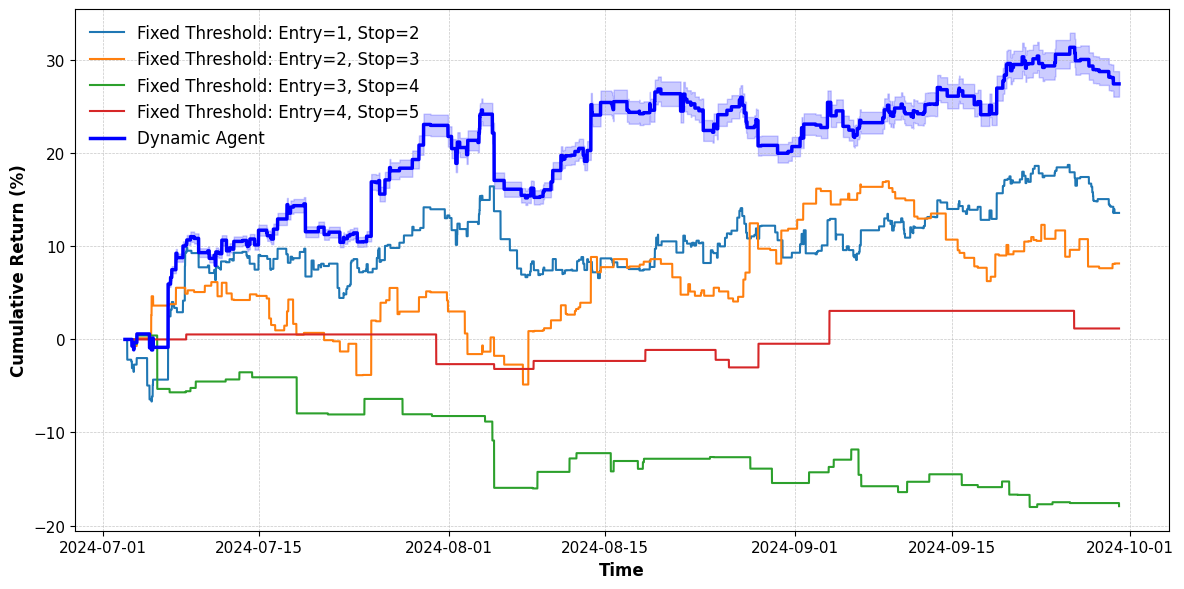

Total trades: 340
Wins: 192, Losses: 148, Forced Exits: 0
Win Rate: 56.47%
Loss Rate: 43.53%
Forced Exit Rate: 0.00%
Missed trades: 3
Number of trades:  340
Total trades: 151
Wins: 101, Losses: 50, Forced Exits: 0
Win Rate: 66.89%
Loss Rate: 33.11%
Forced Exit Rate: 0.00%
Missed trades: 192
Number of trades:  151
Total trades: 50
Wins: 37, Losses: 12, Forced Exits: 1
Win Rate: 74.00%
Loss Rate: 24.00%
Forced Exit Rate: 2.00%
Missed trades: 293
Number of trades:  50
Total trades: 11
Wins: 9, Losses: 2, Forced Exits: 0
Win Rate: 81.82%
Loss Rate: 18.18%
Forced Exit Rate: 0.00%
Missed trades: 332
Number of trades:  11


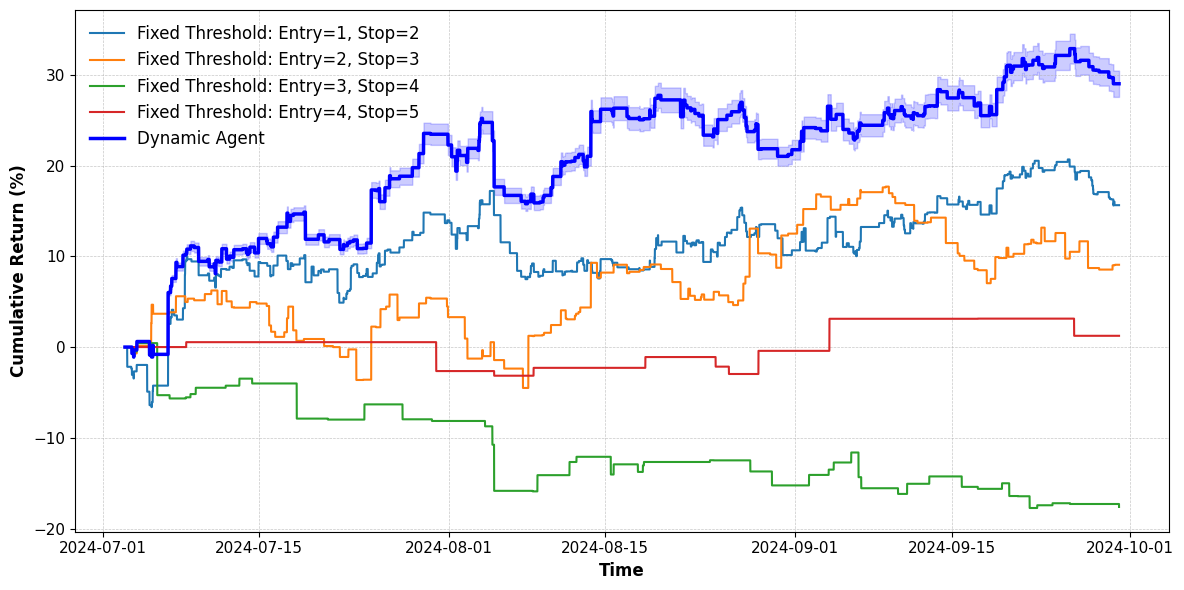

Total trades: 340
Wins: 192, Losses: 148, Forced Exits: 0
Win Rate: 56.47%
Loss Rate: 43.53%
Forced Exit Rate: 0.00%
Missed trades: 3
Number of trades:  340
Total trades: 151
Wins: 101, Losses: 50, Forced Exits: 0
Win Rate: 66.89%
Loss Rate: 33.11%
Forced Exit Rate: 0.00%
Missed trades: 192
Number of trades:  151
Total trades: 50
Wins: 37, Losses: 12, Forced Exits: 1
Win Rate: 74.00%
Loss Rate: 24.00%
Forced Exit Rate: 2.00%
Missed trades: 293
Number of trades:  50
Total trades: 11
Wins: 9, Losses: 2, Forced Exits: 0
Win Rate: 81.82%
Loss Rate: 18.18%
Forced Exit Rate: 0.00%
Missed trades: 332
Number of trades:  11


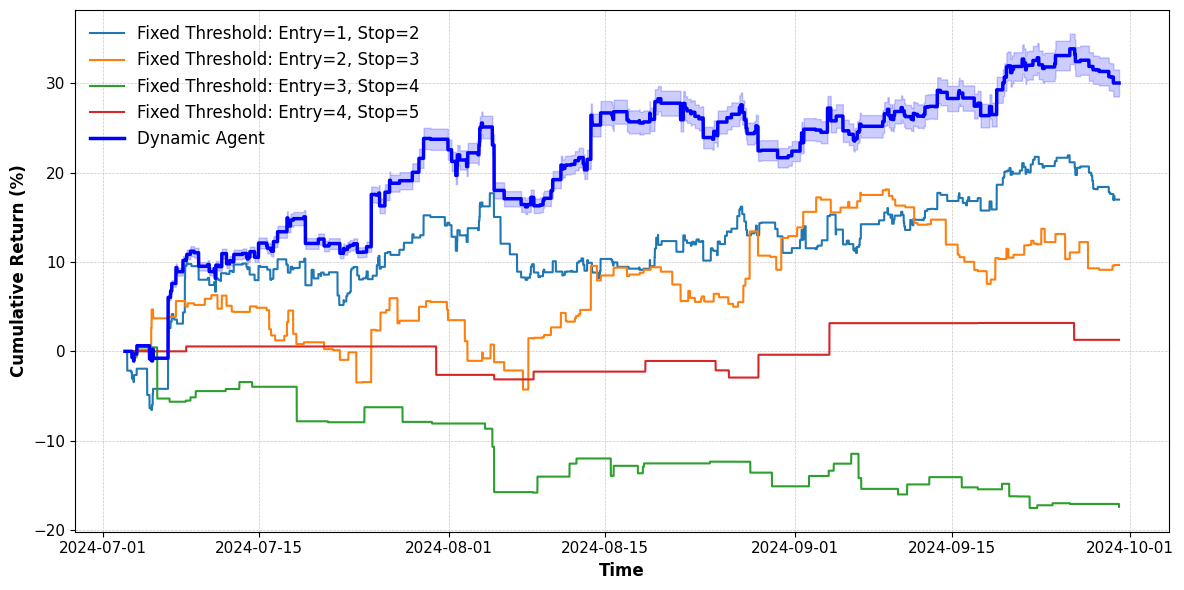

In [ ]:


exit_threshold = 0


#Create list for different transaction costs

tx_costs = [0.0000,0.001, 0.0006, 0.000520, 0.000310, 0.000290, 0.000280, 0.000250, 0.000230]

tx_cost_return_map = {}

trade_metrics_no_tx = [] #Sstores the trade metrics for the strategies when tx_cost = 0.0

#Add transaction costs to the map as keys
for tx_cost in tx_costs:

    tx_cost_return_map[tx_cost] = {}


#Set keys of the map to the transaction costs
for tx_cost in tx_costs:

    returns_map = {} #stores the return for each fixed threshold strategy as well as the agent strategy for the current transaction cost
    
    plt.figure(figsize=(12, 6))  # 🔹 Move outside the loop

    # Track whether we’ve already plotted the agent curve
    agent_plotted = False

    #Create dataframe to store trade metrics for each entry-stop pair
    trade_metrics_dfs = []

    # Plot each fixed threshold strategy
    for idx, entry_stop_pair in enumerate(entry_stop_pairs):
        entry_threshold, stop_loss_threshold = entry_stop_pair
        
        # TEST DATA
        positions, trade_entries, trade_exits = backtest_pair_rolling(S1_test, S2_test, zscore_series_test,
                                                                    entry_threshold, exit_threshold, stop_loss_threshold)
        trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent, \
            cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = \
            simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_test, tx_cost)
        
        #Compute the wins,losses and misses for the "No Agent" strategy
        #--------------------------------------
        total_trades = len(trade_exits)

        wins = 0
        losses = 0
        forced_exits = 0


        for trade_exit in trade_exits:

            result = trade_exit['exit_type']
            if result == 'win':
                wins += 1
            elif result == 'loss':
                losses += 1
            elif result == 'forced_exit':
                forced_exits += 1
                
        print(f"Total trades: {total_trades}")
        print(f"Wins: {wins}, Losses: {losses}, Forced Exits: {forced_exits}")
        # Calculate win rate
        win_rate = wins / total_trades if total_trades > 0 else 0
        print(f"Win Rate: {win_rate:.2%}")
        # Calculate loss rate
        loss_rate = losses / total_trades if total_trades > 0 else 0
        print(f"Loss Rate: {loss_rate:.2%}")
        # Calculate forced exit rate
        forced_exit_rate = forced_exits / total_trades if total_trades > 0 else 0
        print(f"Forced Exit Rate: {forced_exit_rate:.2%}")

        missed_trades = len(env_test.spread_cycles) - total_trades

        print(f"Missed trades: {missed_trades}")
        #--------------------------------------

        trade_exit_times_no_agent = []

        for trade_exit in trade_exits:
            if trade_exit['time'] is not None:
                exit_time = trade_exit['time']
                trade_exit_times_no_agent.append(exit_time)
        
        #Compute annualized Sharpe ratio for the "No Agent" strategy
        risk_free_rate = 0.0  # Assuming no risk-free rate for simplicity
        trade_returns_no_agent = np.array(trade_profits_no_agent) / initial_capital * 100  # Convert to percentage returns
        annualized_sharpe_no_agent = compute_annualized_sharpe_ratio(trade_returns_no_agent, trade_exit_times_no_agent, prices_test.index,initial_capital, risk_free_rate)
        
        #sharpe_ratio_no_agent = compute_sharpe_ratio(initial_capital, trade_profits_no_agent, risk_free_rate)
        #sortino_ratio_no_agent = compute_sortino_ratio(initial_capital, trade_profits_no_agent, risk_free_rate)
        max_drawdown_no_agent = compute_max_drawdown(initial_capital, cumulative_profit_series_no_agent)
        

        #Add the entry and stop pair to the Strategy column
        strategy_name = f" Fixed Strategy: Entry={entry_threshold}, Stop={stop_loss_threshold}"
        trade_metrics_no_agent_df = pd.DataFrame({
            'Strategy': [strategy_name],
            'Cumulative Return (%)': [(cumulative_profit_series_no_agent[-1] / initial_capital) * 100],
            'Annualized Sharpe Ratio': [annualized_sharpe_no_agent],
            #'Sortino Ratio': [sortino_ratio_no_agent],
            'Max Drawdown (%)': [max_drawdown_no_agent],
            'Total # trades': [total_trades],
            'Total # wins': [wins],
            'Total # losses': [losses],
            'Total # missed trades': [missed_trades],
        })

        returns_map[strategy_name] = (cumulative_profit_series_no_agent[-1] / initial_capital) * 100

        trade_metrics_dfs.append(trade_metrics_no_agent_df)
        
        cumulative_profit_series_no_agent_indexed = cumulative_profit_series_no_agent.reindex(prices_test.index, method='ffill').fillna(0)

        cumulative_profit_series_no_agent_indexed_returns = (cumulative_profit_series_no_agent_indexed / initial_capital) * 100

        print("Number of trades: ", len(trade_profits_no_agent))
        
        # Plot each "No Agent" curve with thicker line and better label
        plt.plot(cumulative_profit_series_no_agent_indexed_returns,
                linewidth=1.5,
                label=f"Fixed Threshold: Entry={entry_threshold}, Stop={stop_loss_threshold}")
        
    
    #Recompute agents profits for different transaction costs 
    #-----------------------------------------------------------

    #define test environment
    env_test = PairsTradingEnv(zscore_series_test, prices_test, beta_series_test, initial_capital, tx_cost, entry_stop_pairs, eval_mode=True)

    test_rewards,trade_profits_agent,actions,episodes,test_metrics = evaluate_dqn(
        env_test,
        online_net_trained,
        entry_stop_pairs,
    )

    actual_trade_profits_agent = [profit for profit in trade_profits_agent if profit != 0]

    trade_profits_cumulative_agent = np.cumsum(actual_trade_profits_agent)


    cumulative_profit_series_agent = pd.Series(trade_profits_cumulative_agent, index=agent_trade_exit_times)

    # Calculate the maximum drawdown
    # max_drawdown_agent = compute_max_drawdown(initial_capital,cumulative_profit_series_agent)
    # print("Maximum Drawdown: ", max_drawdown_agent, "%")


    cumulative_profit_series_agent = cumulative_profit_series_agent.reindex(prices_test.index, method='ffill').fillna(0)
    #-----------------------------------------------------------

    trade_exit_times_agent = []

    for episode in episodes:
        if episode['exit_meta'] is not None:
            exit_time = episode['exit_meta']['time']
            trade_exit_times_agent.append(exit_time)

    # Compute annualized Sharpe ratio for the agent strategy
    risk_free_rate = 0.0  # Assuming no risk-free rate for simplicity
    trade_returns_agent = np.array(actual_trade_profits_agent) / initial_capital * 100  # Convert to percentage returns

    annualized_sharpe_agent = compute_annualized_sharpe_ratio(trade_returns_agent, trade_exit_times_agent, prices_test.index, initial_capital, risk_free_rate)

    trade_metrics_agent_df = pd.DataFrame({
        'Strategy': ['Dynamic Agent'],
        'Cumulative Return (%)': [(cumulative_profit_series_agent[-1] / initial_capital) * 100],
        'Annualized Sharpe Ratio': [annualized_sharpe_agent],
        #'Sortino Ratio': [sortino_ratio_agent],
        'Max Drawdown (%)': [max_drawdown_agent],
        'Total # trades': [len(actual_trade_profits_agent)], #These are the trades that actually got executed for the agent
        'Total # wins': [agent_wins],
        'Total # losses': [agent_losses],
        'Total # missed trades': [agent_misses],
    })

    returns_map['Dynamic Agent'] = (cumulative_profit_series_agent[-1] / initial_capital) * 100


    #Append returns_map to the tx_cost_return_map
    tx_cost_return_map[tx_cost] = returns_map
   
    # Append agent metrics to the list
    trade_metrics_dfs.append(trade_metrics_agent_df)

    # Concatenate all trade metrics dataframes
    trade_metrics_df = pd.concat(trade_metrics_dfs, ignore_index=True)

    if tx_cost == 0:
        trade_metrics_no_tx = trade_metrics_df.copy()  # Store the trade metrics for tx_cost = 0.0

    cumulative_profit_series_agent_returns = (cumulative_profit_series_agent / initial_capital) * 100

    # Plot agent curve and shaded band once
    if not agent_plotted:
        plt.plot(cumulative_profit_series_agent_returns,
                color='blue', linewidth=2.5, linestyle='-',
                label='Dynamic Agent')

        margin_fraction = 0.05
        upper_band = cumulative_profit_series_agent_returns * (1 + margin_fraction)
        lower_band = cumulative_profit_series_agent_returns * (1 - margin_fraction)
        # upper_band = 50
        # lower_band = 50

        plt.fill_between(prices_test.index, lower_band, upper_band, color='blue', alpha=0.2)
        agent_plotted = True

    # Add bold, large title
    # plt.title(f'Cumulative Trade Returns: Dynamic Agent vs Fixed Thresholds \n Pair: {sym1_test} ~ {sym2_test} \n Tx Cost: {tx_cost * 100:.4f} %',
    #         fontsize=16, fontweight='bold')

    # Axis labels with large font
    plt.xlabel('Time', fontsize=12, fontweight='bold')
    plt.ylabel('Cumulative Return (%)', fontsize=12, fontweight='bold')

    # Tick sizes
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    # Legend with large font, no frame
    plt.legend(fontsize=12, frameon=False)

    # Optional: add subtle grid to help reader follow cumulative profit
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Tight layout for paper margins
    plt.tight_layout()

    if tx_cost == 0:

        # Save the plot as a high-resolution PNG file
        file_path = f'results/reinforcement_learning/{sym1_test}_{sym2_test}/cumulative_trade_profits_no_tx_{sym1_test}_{sym2_test}.png'
    else:
        # Save the plot as a high-resolution PNG file
        file_path = f'results/reinforcement_learning/{sym1_test}_{sym2_test}/cumulative_trade_returns_with_tx({tx_cost*100:.4f}%)_{sym1_test}_{sym2_test}.png'

    os.makedirs(os.path.dirname(file_path), exist_ok=True)  # Ensure the directory exists
    plt.savefig(file_path, dpi=300, bbox_inches='tight')

    # Show plot
    plt.show()

# Record comparison metrics
---

In [157]:
#Reset transaction cost to 0
tx_cost = 0

#Order the trade metrics DataFrame by Final Return
trade_metrics_no_tx['Cumulative Return (%)'] = trade_metrics_no_tx['Cumulative Return (%)'].astype(float)
trade_metrics_no_tx = trade_metrics_no_tx.sort_values(by='Cumulative Return (%)', ascending=False)

# Save the trade metrics DataFrame to a CSV file
if tx_cost == 0:
    trade_metrics_file_path = f'results/reinforcement_learning/{sym1_test}_{sym2_test}/comparison_trade_metrics_no_tx_{sym1_test}_{sym2_test}.csv'
else:
    trade_metrics_file_path = f'results/reinforcement_learning/{sym1_test}_{sym2_test}/comparison_trade_metrics_with_tx_{sym1_test}_{sym2_test}.csv'
# Ensure the directory exists
if not os.path.exists(os.path.dirname(trade_metrics_file_path)):
    os.makedirs(os.path.dirname(trade_metrics_file_path))
trade_metrics_no_tx.to_csv(trade_metrics_file_path, index=False)
print("Trade Metrics:")
trade_metrics_no_tx

Trade Metrics:


,Strategy,Cumulative Return (%),Annualized Sharpe Ratio,Max Drawdown (%),Total # trades,Total # wins,Total # losses,Total # missed trades
4,Dynamic Agent,41.961603,4.798070,7.021413,259,155,104,83
0,"Fixed Strategy: Entry=1, Stop=2",32.636123,3.787315,7.629824,340,192,148,3
1,"Fixed Strategy: Entry=2, Stop=3",16.617659,1.858909,8.842432,151,101,50,192
3,"Fixed Strategy: Entry=4, Stop=5",1.791665,0.593685,3.574835,11,9,2,332
2,"Fixed Strategy: Entry=3, Stop=4",-15.113296,-2.781816,15.877713,50,37,12,293


# Effect of transaction costs
---

Returns Map for different Transaction Costs:
Transaction Cost: 0.0000%
   Fixed Strategy: Entry=1, Stop=2: 32.64%
   Fixed Strategy: Entry=2, Stop=3: 16.62%
   Fixed Strategy: Entry=3, Stop=4: -15.11%
   Fixed Strategy: Entry=4, Stop=5: 1.79%
  Dynamic Agent: 41.96%

Transaction Cost: 0.1000%
   Fixed Strategy: Entry=1, Stop=2: -35.38%
   Fixed Strategy: Entry=2, Stop=3: -13.58%
   Fixed Strategy: Entry=3, Stop=4: -25.11%
   Fixed Strategy: Entry=4, Stop=5: -0.41%
  Dynamic Agent: -9.85%

Transaction Cost: 0.0600%
   Fixed Strategy: Entry=1, Stop=2: -8.17%
   Fixed Strategy: Entry=2, Stop=3: -1.50%
   Fixed Strategy: Entry=3, Stop=4: -21.11%
   Fixed Strategy: Entry=4, Stop=5: 0.47%
  Dynamic Agent: 10.87%

Transaction Cost: 0.0520%
   Fixed Strategy: Entry=1, Stop=2: -2.73%
   Fixed Strategy: Entry=2, Stop=3: 0.91%
   Fixed Strategy: Entry=3, Stop=4: -20.31%
   Fixed Strategy: Entry=4, Stop=5: 0.65%
  Dynamic Agent: 15.02%

Transaction Cost: 0.0310%
   Fixed Strategy: Entry=1, Stop=2:

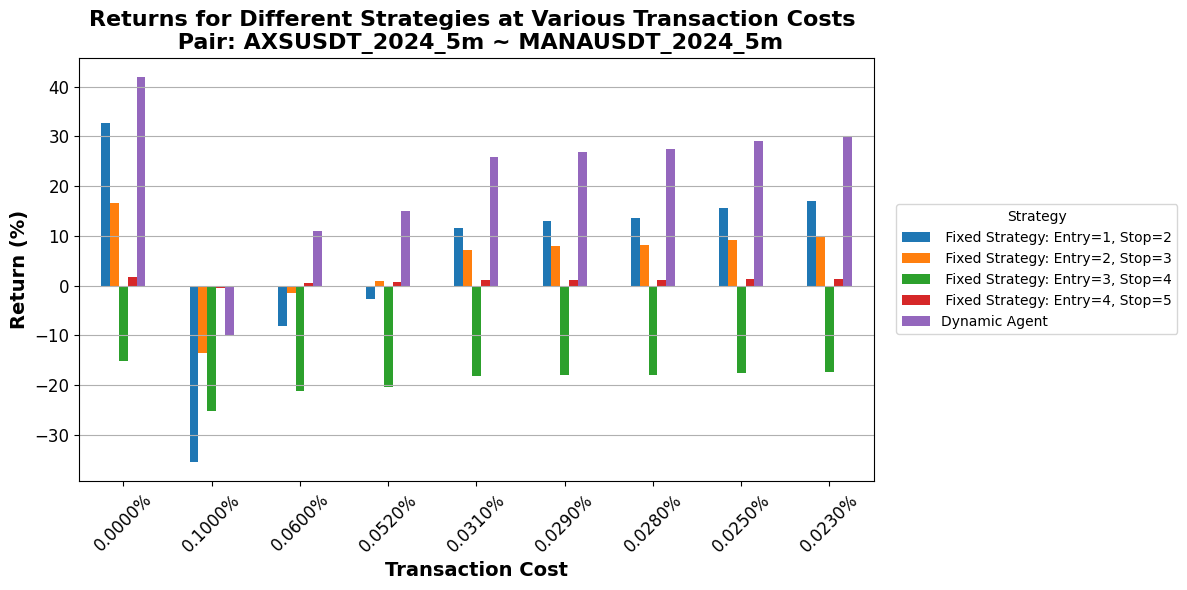

In [ ]:
# Print the returns map for each transaction cost
print("Returns Map for different Transaction Costs:")
for tx_cost, returns in tx_cost_return_map.items():
    print(f"Transaction Cost: {tx_cost * 100:.4f}%")
    for strategy, return_value in returns.items():
        print(f"  {strategy}: {return_value:.2f}%")
    print()  # Add a newline for better readability



# Convert to DataFrame
df = pd.DataFrame(tx_cost_return_map).T   # Convert to percentage
df.index = [f"{x * 100:.4f}%" for x in df.index]

# Plot
ax = df.plot(kind='bar', figsize=(12, 6))
plt.title(f'Returns for Different Strategies at Various Transaction Costs \n Pair: {sym1_test} ~ {sym2_test}', fontsize=16, fontweight='bold')
plt.xlabel('Transaction Cost', fontsize=14, fontweight='bold')
plt.ylabel('Return (%)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
ax.tick_params(axis='both', labelsize=12)             # x & y tick labels
plt.legend(title='Strategy', bbox_to_anchor=(1.02, 0.5), loc='center left')
plt.tight_layout()
plt.grid(axis='y')

# Save the plot as a high-resolution PNG file
file_path = f'results/reinforcement_learning/{sym1_test}_{sym2_test}/returns_comparison_tx_{sym1_test}_{sym2_test}.png'
os.makedirs(os.path.dirname(file_path), exist_ok=True)  # Ensure the directory exists
plt.savefig(file_path, dpi=300, bbox_inches='tight')


plt.show()


In [43]:
counter = 0

for cycle in env_test.spread_cycles[1:]:

    if abs(cycle[0]) >=1:
        counter+=1

print(f"Number of cycles with absolute value >= 1: {counter}")



Number of cycles with absolute value >= 1: 342


/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_2860/2414249668.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(cycle[0]) >=1:


# Case study
---

In [108]:
episodes[2]['cycle_idx']

3

In [109]:
env_test

In [110]:
for episode in episodes:
    if episode['exit_meta'] is not None:
        exit_type = episode['exit_meta']['exit_type']
        print(f"Exit Type: {exit_type}")
        

Exit Type: loss
Exit Type: win
Exit Type: loss
Exit Type: loss
Exit Type: loss
Exit Type: loss
Exit Type: win
Exit Type: loss
Exit Type: loss
Exit Type: win
Exit Type: win
Exit Type: win
Exit Type: win
Exit Type: win
Exit Type: loss
Exit Type: win
Exit Type: win
Exit Type: win
Exit Type: loss
Exit Type: loss
Exit Type: win
Exit Type: loss
Exit Type: win
Exit Type: win
Exit Type: loss
Exit Type: win
Exit Type: win
Exit Type: loss
Exit Type: win
Exit Type: loss
Exit Type: win
Exit Type: loss
Exit Type: win
Exit Type: win
Exit Type: win
Exit Type: win
Exit Type: loss
Exit Type: loss
Exit Type: win
Exit Type: win
Exit Type: loss
Exit Type: loss
Exit Type: loss
Exit Type: loss
Exit Type: loss
Exit Type: win
Exit Type: loss
Exit Type: win
Exit Type: loss
Exit Type: win
Exit Type: win
Exit Type: win
Exit Type: loss
Exit Type: loss
Exit Type: win
Exit Type: win
Exit Type: win
Exit Type: loss
Exit Type: win
Exit Type: loss
Exit Type: win
Exit Type: loss
Exit Type: win
Exit Type: win
Exit Type: 

In [111]:
trade_profits_agent[333]

0.0

In [112]:
episodes[333]

{'cycle_idx': 334,
 'entry_meta': None,
 'exit_meta': None,
 'entry_threshold': 2,
 'stop_threshold': 3}

In [113]:
len(env_test.spread_cycles)

343

In [114]:
episodes[11]

{'cycle_idx': 12,
 'entry_meta': {'time': Timestamp('2024-07-07 01:05:00'),
  'S1': 5.3,
  'S2': 0.3109,
  'z': 1.1882555531756267,
  'position': -1},
 'exit_meta': {'time': Timestamp('2024-07-07 01:55:00'),
  'S1': 5.317,
  'S2': 0.3135,
  'z': -0.2504100326926345,
  'exit_type': 'win'},
 'entry_threshold': 1,
 'stop_threshold': 2}

In [115]:
#Analyze properties of cycles that were lost:

chosen_vs_best_pairs = []

for episode in (episodes):


    if episode['exit_meta'] != None and episode['exit_meta']['exit_type'] == 'loss':
        
        
        #Get the index of the traded cycle
        episode_cycle_index = episode['cycle_idx'] #The spread cycle that was traded in this index

        #Get the threshold chosen for this cycle
        chosen_entry, chosen_stop = episode['entry_threshold'], episode['stop_threshold'] #The entry and stop thresholds chosen for this cycle

        chosen_entry_stop_pair = (chosen_entry, chosen_stop)

        #Get the best threshold pair for this cycle
        best_entry_stop_pair = env_test.best_pairs[episode_cycle_index]


        chosen_vs_best_pairs.append((chosen_entry_stop_pair, env_test.best_pairs[episode_cycle_index]))

       

        # cycle = env_test.spread_cycles[episode_cycle_index] #The actual cycle

print("Chosen vs Best Pairs for Loss Cycles")
print("------------------------------")
chosen_vs_best_pairs



Chosen vs Best Pairs for Loss Cycles
------------------------------


[((1, 2), (2, 3)),
 ((1, 2), (3, 4)),
 ((3, 4), (6, 7)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((2, 3), (3, 4)),
 ((1, 2), (3, 4)),
 ((3, 4), (4, 5)),
 ((2, 3), (3, 4)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((2, 3), (3, 4)),
 ((1, 2), (2, 3)),
 ((1, 2), (3, 4)),
 ((2, 3), (3, 4)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (5, 6)),
 ((2, 3), (3, 4)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((2, 3), (3, 4)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((2, 3), (3, 4)),
 ((1, 2), (2, 3)),
 ((2, 3), (4, 5)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (3, 4)),
 ((3, 4), (5, 6)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((2, 3), (4, 5)),
 ((1, 2), (3, 4)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (3, 4)),
 ((1, 2), (2, 3)),
 ((1, 2), (2, 3)),
 ((1, 2), (3, 4)),
 ((2, 3), (6, 7)),
 ((1, 2), (3, 4)),
 ((1, 2), (3

In [116]:
one_two_counter = 0
two_three_counter = 0
three_four_counter = 0
four_five_counter = 0   

for chosen_pair , best_pair in chosen_vs_best_pairs:

    if chosen_pair == (1, 2) and best_pair == (1, 2):
        one_two_counter += 1
    elif chosen_pair == (2, 3) and best_pair == (2, 3):
        two_three_counter += 1
    elif chosen_pair == (3, 4) and best_pair == (3, 4):
        three_four_counter += 1
    elif chosen_pair == (4, 5) and best_pair == (4, 5):
        four_five_counter += 1

print("------------------------------")
print(f"Chosen (1, 2) vs Best (1, 2): {one_two_counter}")
print(f"Chosen (2, 3) vs Best (2, 3): {two_three_counter}")
print(f"Chosen (3, 4) vs Best (3, 4): {three_four_counter}")
print(f"Chosen (4, 5) vs Best (4, 5): {four_five_counter}")
    


------------------------------
Chosen (1, 2) vs Best (1, 2): 0
Chosen (2, 3) vs Best (2, 3): 0
Chosen (3, 4) vs Best (3, 4): 0
Chosen (4, 5) vs Best (4, 5): 0


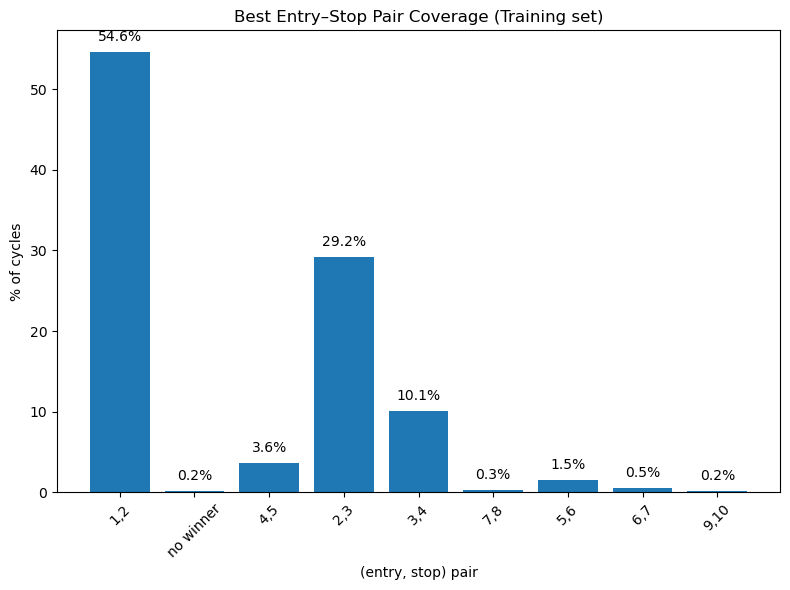

In [117]:
#Compare distirbution of best_pairs in training set and testing set
training_env = PairsTradingEnv(
        zscore_series_train, prices_train, beta_series_train,
        initial_capital, tx_cost,
        entry_stop_pairs,
        eval_mode=False) #Set eval_mode to False for training

#Plot distribution of best pairs in training set
training_best_pairs = training_env.best_pairs
training_counts = Counter(training_best_pairs)
# Convert raw counts to percentages
training_pairs = list(training_counts.keys())
training_percentages = [training_counts[p] / len(training_best_pairs) * 100 for p in training_pairs]
# Turn None → a string label
training_labels = [
    "no winner" if p is None else f"{p[0]},{p[1]}"
    for p in training_pairs
]
# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(training_labels)), training_percentages, tick_label=training_labels)
plt.ylabel("% of cycles")
plt.xlabel("(entry, stop) pair")
# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', va='bottom')
plt.xticks(rotation=45)
plt.title("Best Entry–Stop Pair Coverage (Training set)")
plt.tight_layout()


In [118]:
training_best_pairs

[(1, 2),
 (1, 2),
 None,
 (1, 2),
 (1, 2),
 (4, 5),
 (1, 2),
 (2, 3),
 (1, 2),
 (2, 3),
 (3, 4),
 (1, 2),
 (2, 3),
 (3, 4),
 (3, 4),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (2, 3),
 (1, 2),
 (2, 3),
 (1, 2),
 (2, 3),
 (1, 2),
 (3, 4),
 (2, 3),
 (4, 5),
 (1, 2),
 (1, 2),
 (1, 2),
 (3, 4),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (2, 3),
 (3, 4),
 (1, 2),
 (3, 4),
 (1, 2),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (4, 5),
 (1, 2),
 (2, 3),
 (7, 8),
 (1, 2),
 (1, 2),
 (2, 3),
 (2, 3),
 (1, 2),
 (3, 4),
 (3, 4),
 (2, 3),
 (2, 3),
 (1, 2),
 (1, 2),
 (2, 3),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (2, 3),
 (3, 4),
 (1, 2),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (5, 6),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (3, 4),
 (1, 2),
 (2, 3),
 (1, 2),
 (3, 4),
 (1, 2),
 (1, 2),
 (1, 2),
 (2, 3),
 (1, 2),
 (2, 3),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (3, 4),
 (2, 3),
 (2, 3),
 (1, 2),
 (3, 4),
 (4, 5),
 (1, 2),
 (7, 8),
 (2, 3),
 (2, 3),
 (1, 2),
 (2

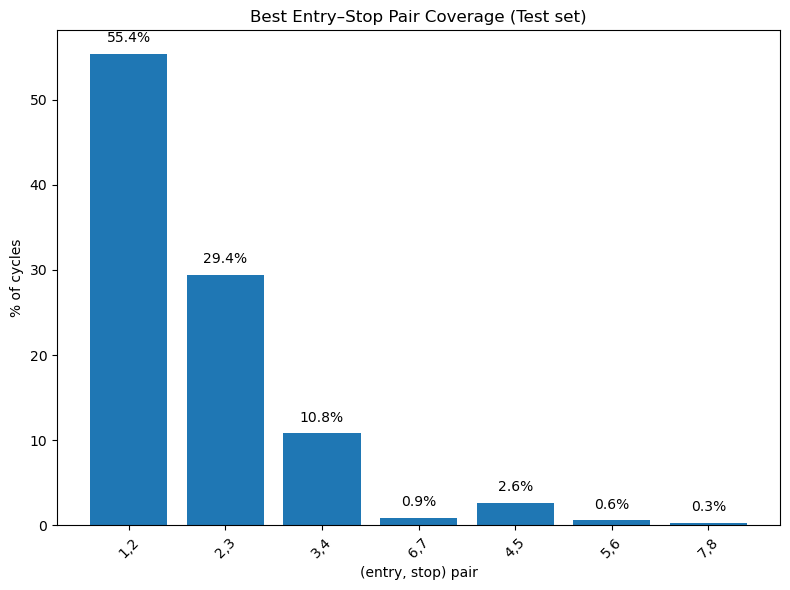

In [119]:
testing_best_pairs = env_test.best_pairs
testing_counts = Counter(testing_best_pairs)
# Convert raw counts to percentages
testing_pairs = list(testing_counts.keys())
testing_percentages = [testing_counts[p] / len(testing_best_pairs) * 100 for p in testing_pairs]
# Turn None → a string label
testing_labels = [
    "no winner" if p is None else f"{p[0]},{p[1]}"
    for p in testing_pairs
]
# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(testing_labels)), testing_percentages, tick_label=testing_labels)
plt.ylabel("% of cycles")
plt.xlabel("(entry, stop) pair")
# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', va='bottom')
plt.xticks(rotation=45)
plt.title("Best Entry–Stop Pair Coverage (Test set)")
plt.tight_layout()

In [120]:
CUMULATIVE_AXS_MANA = np.cumsum(AXS_MANA_PROFITS_NO_TX) 
CUMULATIVE_MANA_SAND = np.cumsum(MANA_SAND_PROFITS_NO_TX)

#Print average profits for AXS-MANA and MANA-SAND trades
print("Average AXS-MANA Profit (No TX):", np.mean(AXS_MANA_PROFITS_NO_TX))
print("Average MANA-SAND Profit (No TX):", np.mean(MANA_SAND_PROFITS_NO_TX))

#Plotting the cumulative profits
plt.figure(figsize=(14, 7))
plt.plot(CUMULATIVE_AXS_MANA, label='Cumulative AXS-MANA Profits (No TX)', color='blue')
plt.plot(CUMULATIVE_MANA_SAND, label='Cumulative MANA-SAND Profits (No TX)', color='orange')
plt.title('Cumulative Profits Comparison')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative Profit (USD)')
plt.legend()



NameError: name 'AXS_MANA_PROFITS_NO_TX' is not defined

# Save final results 
---

In [60]:
# #Create a dataframe to store the number of epochs, trials, best hyperparameters, best reward, training metrics and test metrics
# df_results = pd.DataFrame({
#     'num_epochs': [num_epochs],
#     'n_trials': [n_trials],
#     'best_hyperparameters': [best_params],
#     'best_validation_reward': [best_reward],
#     'training_metrics': [training_metrics],
#     'test_metrics': [test_metrics],
#     'final_return_test_set (%)': [final_return_test_set]
# })
  

In [61]:
# df_results.to_csv('results/reinforcement_learning/MANAUSDT_SANDUSDT_results.csv', header=False, mode='a', index=False)

In [62]:
# read_test = pd.read_csv('results/reinforcement_learning/MANAUSDT_SANDUSDT_results.csv', parse_dates=True)
# read_test